In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import time
import tensorflow as tf

2022-11-16 19:17:02.478166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read our New York registrations Dataset

In [2]:
NYS_registrations_df = pd.read_csv('Resources/NYS Electric Vehicle Registrations.csv')
NYS_registrations_df.head()

,Record Type,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,Unladen Weight,Maximum Gross Weight,Passengers,Reg Valid Date,Reg Expiration Date,Color,Scofflaw Indicator,Suspension Indicator,Revocation Indicator
0,VEH,96722014661,SRF,BOVINA,NY,13740,DELAWARE,1972,SAAB,2DSD,ELECTRIC,2000.0,NaN,NaN,05/04/2021,06/26/2023,WH,N,N,N
1,VEH,9106843,SRF,GLENDALE,NY,11385,QUEENS,1974,EVA,4DSD,ELECTRIC,2180.0,NaN,NaN,09/21/2021,10/03/2023,BR,N,N,N
2,VEH,909SR2223A,SRF,STAFFORD,NY,14143,GENESEE,1979,CITIC,2DSD,ELECTRIC,850.0,NaN,NaN,05/12/2021,04/01/2023,GR,N,N,N
3,VEH,9E2SPAXBC113501,PSD,JOHNSTOWN,NY,12095,FULTON,2012,VANTA,PICK,ELECTRIC,1900.0,NaN,NaN,07/01/2014,NaN,WH,N,N,N
4,VEH,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,CROWN,P/SH,ELECTRIC,3335.0,NaN,NaN,12/09/2021,12/31/2022,WH,N,N,N


In [3]:
NYS_registrations_df.columns

Index(['Record Type', 'VIN', 'Registration Class', 'City', 'State', 'Zip',
       'County', 'Model Year', 'Make', 'Body Type', 'Fuel Type',
       'Unladen Weight', 'Maximum Gross Weight', 'Passengers',
       'Reg Valid Date', 'Reg Expiration Date', 'Color', 'Scofflaw Indicator',
       'Suspension Indicator', 'Revocation Indicator'],
      dtype='object')

In [4]:
#  Let's drop the columns we will not use
drop_cols = ['Record Type', 'Unladen Weight', 'Maximum Gross Weight', 'Passengers',
          'Reg Expiration Date', 'Color', 'Scofflaw Indicator',
       'Suspension Indicator', 'Revocation Indicator']
NYS_registrations_df.drop(drop_cols, axis=1, inplace=True)
NYS_registrations_df.head()

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,Reg Valid Date
0,96722014661,SRF,BOVINA,NY,13740,DELAWARE,1972,SAAB,2DSD,ELECTRIC,05/04/2021
1,9106843,SRF,GLENDALE,NY,11385,QUEENS,1974,EVA,4DSD,ELECTRIC,09/21/2021
2,909SR2223A,SRF,STAFFORD,NY,14143,GENESEE,1979,CITIC,2DSD,ELECTRIC,05/12/2021
3,9E2SPAXBC113501,PSD,JOHNSTOWN,NY,12095,FULTON,2012,VANTA,PICK,ELECTRIC,07/01/2014
4,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,CROWN,P/SH,ELECTRIC,12/09/2021


In [5]:
# Registration VIN count
Registration = NYS_registrations_df.VIN.count()
Registration

62063

In [6]:
NYS_registrations_df['Reg Valid Date'] = pd.to_datetime(NYS_registrations_df['Reg Valid Date'])
NYS_registrations_df.head()

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,Reg Valid Date
0,96722014661,SRF,BOVINA,NY,13740,DELAWARE,1972,SAAB,2DSD,ELECTRIC,2021-05-04
1,9106843,SRF,GLENDALE,NY,11385,QUEENS,1974,EVA,4DSD,ELECTRIC,2021-09-21
2,909SR2223A,SRF,STAFFORD,NY,14143,GENESEE,1979,CITIC,2DSD,ELECTRIC,2021-05-12
3,9E2SPAXBC113501,PSD,JOHNSTOWN,NY,12095,FULTON,2012,VANTA,PICK,ELECTRIC,2014-07-01
4,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,CROWN,P/SH,ELECTRIC,2021-12-09


In [7]:
# We will be using the m/y information to clean duplicates 
NYS_registrations_df['month/year'] = NYS_registrations_df['Reg Valid Date'].dt.strftime("%m-%Y")

# Then we will adjust the index of our New York registration Database
NYS_registrations_df.set_index('Reg Valid Date', inplace=True)
NYS_registrations_df.head()

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,month/year
Reg Valid Date,,,,,,,,,,,
2021-05-04,96722014661,SRF,BOVINA,NY,13740,DELAWARE,1972,SAAB,2DSD,ELECTRIC,05-2021
2021-09-21,9106843,SRF,GLENDALE,NY,11385,QUEENS,1974,EVA,4DSD,ELECTRIC,09-2021
2021-05-12,909SR2223A,SRF,STAFFORD,NY,14143,GENESEE,1979,CITIC,2DSD,ELECTRIC,05-2021
2014-07-01,9E2SPAXBC113501,PSD,JOHNSTOWN,NY,12095,FULTON,2012,VANTA,PICK,ELECTRIC,07-2014
2021-12-09,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,CROWN,P/SH,ELECTRIC,12-2021


# Looking for duplicates

In [8]:
# let's see the duplicates accross the data set
duplicates = NYS_registrations_df[NYS_registrations_df.duplicated()]
duplicates.count()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
month/year            0
dtype: int64

In [9]:
# inspection of City duplicates
NYS_registrations_df[NYS_registrations_df.duplicated('City')]

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,month/year
Reg Valid Date,,,,,,,,,,,
2022-01-31,7SAYGDEF9NF365467,PAS,BROOKLYN,NY,11249,KINGS,2022,TESLA,SUBN,ELECTRIC,01-2022
2022-01-12,7SAYGDEF9NF337765,OMT,BROOKLYN,NY,11229,KINGS,2022,TESLA,SUBN,ELECTRIC,01-2022
2021-12-15,7SAYGDEF9NF328094,PAS,BRONX,NY,10465,BRONX,2022,TESLA,SUBN,ELECTRIC,12-2021
2021-12-18,7SAYGDEF9NF326491,PAS,NEW YORK,NY,10025,NEW YORK,2022,TESLA,SUBN,ELECTRIC,12-2021
2022-01-18,7SAYGDEF9NF325096,PAS,STATEN ISLAND,NY,10305,RICHMOND,2022,TESLA,SUBN,ELECTRIC,01-2022
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,A976B08198T,SPC,BROOKLYN,NY,11232,KINGS,2019,YALE,SWT,ELECTRIC,10-2021
2021-10-27,A976B07325S,SPC,BROOKLYN,NY,11232,KINGS,2018,YALE,P/SH,ELECTRIC,10-2021
2021-10-27,A976B06198R,SPC,BROOKLYN,NY,11232,KINGS,2017,YALE,P/SH,ELECTRIC,10-2021


In [10]:
# inspection of Date/VIN/County duplicates
inspection= NYS_registrations_df[NYS_registrations_df.duplicated(subset=['month/year','VIN', 'County'], keep=False)].sort_values('VIN')
inspection.count()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
month/year            0
dtype: int64

In [11]:
# inspection of Date/VIN duplicates
inspect_date_vin = NYS_registrations_df[NYS_registrations_df.duplicated(subset=['month/year','VIN'], keep=False)].sort_values('VIN')
inspect_date_vin.count()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
month/year            0
dtype: int64

# Addressing potential Null Values

In [12]:
NYS_registrations_df.isna().sum()

VIN                   0
Registration Class    0
City                  0
State                 0
Zip                   0
County                0
Model Year            0
Make                  0
Body Type             0
Fuel Type             0
month/year            0
dtype: int64

In [13]:
NYS_registrations_df['Make'].unique()

array(['SAAB', 'EVA', 'CITIC', 'VANTA', 'CROWN', 'DE/EL', 'MANIT',
       'HONDA', 'TESLA', 'AMPER', 'PROTE', 'VOLVO', 'CENNT', 'ARCIM',
       'RIVIA', 'TOYOT', 'WORKH', 'GENZE', 'LEXUS', 'ALTA', 'ZERO',
       'ZE/MO', 'AZURE', 'FORD', 'THINK', 'GREEN', 'SCOUT', 'NAVIS',
       'INTER', 'STAR', 'POLAR', 'GEM', 'GLOBA', 'LINDE', 'BRAMM',
       'AM/GE', 'KARMA', 'KARM', 'LUCID', 'CRUS', 'MOKE', 'CR/CA', 'TESL',
       'BMW', 'TO/OU', 'ACURA', 'CLUBC', 'CL/CA', 'CLUB', 'PATH', 'ZO/EL',
       'NEWFL', 'NE/FL', 'COLUM', 'TOMBE', 'SPARK', 'SMITH', 'UTILI',
       'NOVA', 'NOVB', 'NO/BU', 'IC', 'CR/CO', 'MITSU', 'LINCO', 'RAM',
       'ZENIT', 'ZENTI', 'FIAT', 'PIAGG', 'CHEVR', 'GMC', 'ZENN', 'CHRYS',
       'LION', 'GILLI', 'DETRO', 'VOLKS', 'ASVE', 'EA/BE', 'COM', 'COMUT',
       'CO/CA', 'KALMA', 'AMPHI', 'CRAYL', 'CUSHM', 'EZ/GO', 'OHAWA',
       'ORANG', 'ORAN', 'ZELEC', 'ZEV', 'ORION', 'OROIN', 'ORON', 'IRION',
       'OTION', 'NISSA', 'PRO', 'JOHND', 'JO/DE', 'LI/SE', 'STING',
    

In [14]:
len(NYS_registrations_df['Make'].unique())

197

In [15]:
# Next we can see some vehicles name are just mispelled or have an a different name , we will group by the OEM.
NYS_registrations_df['Make'].replace(['CROWN', 'TOYOT'], 'TOYOTA', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['ORION','OTION','OROIN','IRION','ORON','ENERG'], 'FORD', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['NOVB', 'NOVA','IRION'], 'NOVA BUS', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['NEWFL', 'NE/FL'], 'NEW FLYER', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['DOOH', 'DOOHA'], 'DOOHAN', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['JAGUA','JAG'], 'JAGUAR', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['ORAN','ORANG'], 'ORANGE EV', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['MILE','MILES'], 'MILES EV', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['GENU','GENUI'], 'GENESIS', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['KARM', 'FISKE','KALMA'], 'KARMA', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['PIAGG','VESPA'], 'PIAGGIO', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['ZERO','ZE/MO'], 'ZERO EV', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['POLRD','POLAR','POLES','POLE'], 'POLESTAR', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['CITIC','CITC'], 'HONDA', 
                    inplace=True)
NYS_registrations_df['Make'].replace(['VOLKS', 'SCOUT'],'VOLKSWAGEN',
                    inplace=True)
NYS_registrations_df['Make'].replace(['CHRIS','CHRYS','CRAYL'], 
                    'CHRYSLER', inplace=True)
NYS_registrations_df['Make'].replace('SUBAR', 'SUBARU', inplace=True)
NYS_registrations_df['Make'].replace('TESL', 'TESLA', inplace=True)
NYS_registrations_df['Make'].replace('FREIG', 'FREIGHT LINER', inplace=True)
NYS_registrations_df['Make'].replace('PORSC', 'PORSCHE', inplace=True)
NYS_registrations_df['Make'].replace('NIUU', 'NIU', inplace=True)
NYS_registrations_df['Make'].replace('LINCO', 'LINCOLN', inplace=True)
NYS_registrations_df['Make'].replace('VANTA', 'BMW', inplace=True)
NYS_registrations_df['Make'].replace('CASE', 'CAKE', inplace=True)
NYS_registrations_df['Make'].replace('NISSA', 'NISSAN', inplace=True)
NYS_registrations_df['Make'].replace('SUZUK', 'SUZUKI', inplace=True)
NYS_registrations_df['Make'].replace('RIVIA', 'RIVIAN', inplace=True)
NYS_registrations_df['Make'].replace('GREEN', 'GREENPOWER MOTORS', inplace=True)
NYS_registrations_df['Make'].replace('HYUND', 'HYUNDAI', inplace=True)
NYS_registrations_df['Make'].replace('CENNT', 'CENNTRO', inplace=True)
NYS_registrations_df['Make'].replace('PROTE', 'PROTERRA', inplace=True)
NYS_registrations_df['Make'].replace(['INTER','STAR','OTHER'], 'INTERNATIONAL',
                                     inplace=True)
NYS_registrations_df['Make'].replace(['MITSU','FUSO' ],'MITSUBISHI', 
                                     inplace=True)
NYS_registrations_df['Make'].replace(['IC','ICE','IC/PN' ],'ICBUS', 
                                     inplace=True)
NYS_registrations_df['Make'].replace('ZELEC', 'ZELECTRIC MOTORS', inplace=True)
NYS_registrations_df['Make'].replace('KAWAS', 'KAWASAKI', inplace=True)
NYS_registrations_df['Make'].replace('EVA', 'EVI', inplace=True)
NYS_registrations_df['Make'].replace('EVTA', 'EVT', inplace=True)
NYS_registrations_df['Make'].replace('CHEVR', 'CHEVROLET', inplace=True)

In [16]:
NYS_registrations_df['Make'].unique()

array(['SAAB', 'EVI', 'HONDA', 'BMW', 'TOYOTA', 'DE/EL', 'MANIT', 'TESLA',
       'AMPER', 'PROTERRA', 'VOLVO', 'CENNTRO', 'ARCIM', 'RIVIAN',
       'WORKH', 'GENZE', 'LEXUS', 'ALTA', 'ZERO EV', 'AZURE', 'FORD',
       'THINK', 'GREENPOWER MOTORS', 'VOLKSWAGEN', 'NAVIS',
       'INTERNATIONAL', 'POLESTAR', 'GEM', 'GLOBA', 'LINDE', 'BRAMM',
       'AM/GE', 'KARMA', 'LUCID', 'CRUS', 'MOKE', 'CR/CA', 'TO/OU',
       'ACURA', 'CLUBC', 'CL/CA', 'CLUB', 'PATH', 'ZO/EL', 'NEW FLYER',
       'COLUM', 'TOMBE', 'SPARK', 'SMITH', 'UTILI', 'NOVA BUS', 'NO/BU',
       'ICBUS', 'CR/CO', 'MITSUBISHI', 'LINCOLN', 'RAM', 'ZENIT', 'ZENTI',
       'FIAT', 'PIAGGIO', 'CHEVROLET', 'GMC', 'ZENN', 'CHRYSLER', 'LION',
       'GILLI', 'DETRO', 'ASVE', 'EA/BE', 'COM', 'COMUT', 'CO/CA',
       'AMPHI', 'CUSHM', 'EZ/GO', 'OHAWA', 'ORANGE EV',
       'ZELECTRIC MOTORS', 'ZEV', 'NISSAN', 'PRO', 'JOHND', 'JO/DE',
       'LI/SE', 'STING', 'HA/DA', 'LIVEW', 'MEVH', 'CADIL',
       'FREIGHT LINER', 'TRANT', 'EGO', 'ETU

In [17]:
len(NYS_registrations_df['Make'].unique())
# A DROP FROM 197 TO 166

162

In [18]:
NYS_registrations_df

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,month/year
Reg Valid Date,,,,,,,,,,,
2021-05-04,96722014661,SRF,BOVINA,NY,13740,DELAWARE,1972,SAAB,2DSD,ELECTRIC,05-2021
2021-09-21,9106843,SRF,GLENDALE,NY,11385,QUEENS,1974,EVI,4DSD,ELECTRIC,09-2021
2021-05-12,909SR2223A,SRF,STAFFORD,NY,14143,GENESEE,1979,HONDA,2DSD,ELECTRIC,05-2021
2014-07-01,9E2SPAXBC113501,PSD,JOHNSTOWN,NY,12095,FULTON,2012,BMW,PICK,ELECTRIC,07-2014
2021-12-09,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,TOYOTA,P/SH,ELECTRIC,12-2021
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,A976B08198T,SPC,BROOKLYN,NY,11232,KINGS,2019,YALE,SWT,ELECTRIC,10-2021
2021-10-27,A976B07325S,SPC,BROOKLYN,NY,11232,KINGS,2018,YALE,P/SH,ELECTRIC,10-2021
2021-10-27,A976B06198R,SPC,BROOKLYN,NY,11232,KINGS,2017,YALE,P/SH,ELECTRIC,10-2021


In [19]:
NYS_registrations_df['Make' ].value_counts()

TESLA        37137
NIU           6918
HYUNDAI       3130
FORD          3082
CHEVROLET     3044
             ...  
CUSHM            1
AMPHI            1
CO/CA            1
COMUT            1
TCM              1
Name: Make, Length: 162, dtype: int64

In [20]:
# Looking at the Make for Yale to see if it's actually a car.
# base on the registration class  SPC stand for self parking cars as found here https://www.allacronyms.com/SPC/car
NYS_registrations_df[NYS_registrations_df['Make' ]=='YALE']

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,month/year
Reg Valid Date,,,,,,,,,,,
2021-12-09,N336261,SPC,HAUPPAUGE,NY,11788,SUFFOLK,1978,YALE,SWT,ELECTRIC,12-2021
2021-11-21,N30346,SPC,NEW YORK,NY,10002,NEW YORK,1972,YALE,P/SH,ELECTRIC,11-2021
2021-12-14,G807N09683P,SPC,BROOKLYN,NY,11218,KINGS,2016,YALE,P/SH,ELECTRIC,12-2021
2021-11-24,G807N09057N,SPC,BROOKLYN,NY,11206,KINGS,2015,YALE,P/SH,ELECTRIC,11-2021
2021-10-29,F807N04372D,SPC,ASTORIA,NY,11105,QUEENS,2006,YALE,SWT,ELECTRIC,10-2021
2021-10-29,E216A01721E,SPC,ASTORIA,NY,11105,QUEENS,2007,YALE,SWT,ELECTRIC,10-2021
2021-10-29,E216A01715E,SPC,ASTORIA,NY,11105,QUEENS,2007,YALE,SWT,ELECTRIC,10-2021
2021-12-14,D875V06421P,SPC,BROOKLYN,NY,11218,KINGS,2016,YALE,P/SH,ELECTRIC,12-2021
2021-12-14,D875V06225P,SPC,BROOKLYN,NY,11218,KINGS,2016,YALE,P/SH,ELECTRIC,12-2021


In [21]:
# for the purpose of our analysis , we will filter  the dataset by Model year equal or  later than 2012 to have a decade of dataset.
NYS_registrations_df= NYS_registrations_df[NYS_registrations_df['Model Year'] >= 2012] 
NYS_registrations_df

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,month/year
Reg Valid Date,,,,,,,,,,,
2014-07-01,9E2SPAXBC113501,PSD,JOHNSTOWN,NY,12095,FULTON,2012,BMW,PICK,ELECTRIC,07-2014
2021-12-09,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,TOYOTA,P/SH,ELECTRIC,12-2021
2021-11-16,9A19709,SPC,FARMINGDALE,NY,11735,SUFFOLK,2013,TOYOTA,SWT,ELECTRIC,11-2021
2021-10-19,854087,SPC,DEPEW,NY,14043,ERIE,2016,MANIT,SWT,ELECTRIC,10-2021
2021-08-11,7.85E+14,LMB,STATEN ISLAND,NY,10302,RICHMOND,2019,HONDA,MOPD,ELECTRIC,08-2021
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,A976B09580U,SPC,BROOKLYN,NY,11232,KINGS,2020,YALE,P/SH,ELECTRIC,01-2022
2021-10-27,A976B08198T,SPC,BROOKLYN,NY,11232,KINGS,2019,YALE,SWT,ELECTRIC,10-2021
2021-10-27,A976B07325S,SPC,BROOKLYN,NY,11232,KINGS,2018,YALE,P/SH,ELECTRIC,10-2021


In [22]:
# Registration VIN count
Registration = NYS_registrations_df.VIN.count()
Registration

59955

In [23]:
#let's get unique values  for the Make
Make_counts = NYS_registrations_df.Make.value_counts()
Make_counts

TESLA        37113
NIU           6916
HYUNDAI       3130
CHEVROLET     3038
NISSAN        2232
             ...  
FLYWI            1
LINCOLN          1
MOFFE            1
CR/CO            1
DOOSA            1
Name: Make, Length: 125, dtype: int64

In [24]:
#let's get unique values  for the Model Year
Model_year_counts = NYS_registrations_df['Model Year'].value_counts()
Model_year_counts

2021    23413
2020    13130
2019     5978
2018     5863
2022     5415
2017     2320
2016     1527
2015      928
2014      562
2013      551
2012      268
Name: Model Year, dtype: int64

In [25]:
#let's get unique values  for the Registration class
Regist_class_counts = NYS_registrations_df['Registration Class'].value_counts()
Regist_class_counts

PAS    45616
LMB     6915
SRF     2907
PSD     1125
OMT      759
MED      531
ORG      482
MOT      373
LUA      354
OMS      230
COM      144
RGL      144
SPO      104
STA       51
OMR       37
HAM       29
ITP       28
SPC       24
VAS       18
ATV       15
BOB       11
LMC       10
SRN       10
TRC        8
LMA        7
OML        5
ARG        4
OMV        2
ORM        2
SUP        2
JCA        1
SOS        1
STG        1
NYA        1
AGR        1
SCL        1
AYG        1
JSC        1
Name: Registration Class, dtype: int64

In [26]:
#let's get unique values for City
City_counts= NYS_registrations_df.City.value_counts()
City_counts

BROOKLYN         10075
NEW YORK          3017
STATEN ISLAND     1270
ROCHESTER         1113
BRONX              830
                 ...  
STERLINGTON          1
MELLENVILLE          1
WYANTSKILL           1
SHERMAN              1
BROOKLNY             1
Name: City, Length: 1956, dtype: int64

In [27]:
#let's get unique values  for County
County_counts= NYS_registrations_df.County.value_counts()
County_counts

KINGS          10212
NASSAU          8531
SUFFOLK         7369
WESTCHESTER     7170
QUEENS          3883
               ...  
SENECA            31
ALLEGANY          23
WYOMING           19
LEWIS             10
HAMILTON           6
Name: County, Length: 63, dtype: int64

In [28]:
# if everyone good with this I can't save the clean dataset as a new csv then after doing the same for the charging stations we can merge in one datasets.
# we can even decrease the dataset by filtering for the last 5 years.

In [29]:
'''Slicing out new car purchases for each county, parsing information to a 
dictionary, changing index to be monthly and taking cumulative sum to convert
information to cars on the road'''

county_dict = {}
for county in list(NYS_registrations_df ['County'].unique()):
    county_dict[county] = NYS_registrations_df[
        (NYS_registrations_df['County']==county)
        
    ].resample('M').size().cumsum()

In [30]:
#filling null values created by resampling with 0's.
df_cumsum = pd.DataFrame(county_dict)
df_cumsum.fillna(0, inplace=True)
df_cumsum.head()

,FULTON,KINGS,SUFFOLK,ERIE,RICHMOND,NASSAU,ROCKLAND,QUEENS,WESTCHESTER,SARATOGA,...,CATTARAUGUS,HERKIMER,HAMILTON,MONTGOMERY,ORLEANS,YATES,FRANKLIN,DELAWARE,WASHINGTON,CHENANGO
Reg Valid Date,,,,,,,,,,,,,,,,,,,,,
2014-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-07-31,1.0,4.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-08-31,1.0,4.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Electric Vehicles on the Road in NY State Over Time

Before we take a look at the electric vehicle trends for each county, it is important to see the larger picture by looking at the statewide trend.

In [31]:
#summing each row to get monthly statewide total 
df_cumsum['State Total'] = df_cumsum.sum(axis=1)
df_cumsum.head()

,FULTON,KINGS,SUFFOLK,ERIE,RICHMOND,NASSAU,ROCKLAND,QUEENS,WESTCHESTER,SARATOGA,...,HERKIMER,HAMILTON,MONTGOMERY,ORLEANS,YATES,FRANKLIN,DELAWARE,WASHINGTON,CHENANGO,State Total
Reg Valid Date,,,,,,,,,,,,,,,,,,,,,
2014-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2014-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2014-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2014-07-31,1.0,4.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0
2014-08-31,1.0,4.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0


In [32]:
df_cumsum = df_cumsum.reset_index()
df_cumsum.head()

,Reg Valid Date,FULTON,KINGS,SUFFOLK,ERIE,RICHMOND,NASSAU,ROCKLAND,QUEENS,WESTCHESTER,...,HERKIMER,HAMILTON,MONTGOMERY,ORLEANS,YATES,FRANKLIN,DELAWARE,WASHINGTON,CHENANGO,State Total
0,2014-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,2014-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,2014-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
3,2014-07-31,1.0,4.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0
4,2014-08-31,1.0,4.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0


In [33]:
#saving the df for dashboarding
path = 'Resources'
output_file = os.path.join(path,f'vehicles_on_the_road.csv')
df_cumsum.to_csv(output_file, index=False)

# Diagrams

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

### Electric Vehicles on the Road in NYS (2012-2021)

In [35]:
Model_year_counts_df = pd.DataFrame(Model_year_counts)
Model_year_counts_df= Model_year_counts_df.reset_index()
Model_year_counts_df.columns = ['Year','Total Counts']
Model_year_counts_df

,Year,Total Counts
0,2021,23413
1,2020,13130
2,2019,5978
3,2018,5863
4,2022,5415
5,2017,2320
6,2016,1527
7,2015,928
8,2014,562
9,2013,551


In [36]:
# Drop the data for year 2022
Model_year_counts_df = Model_year_counts_df.drop(4)

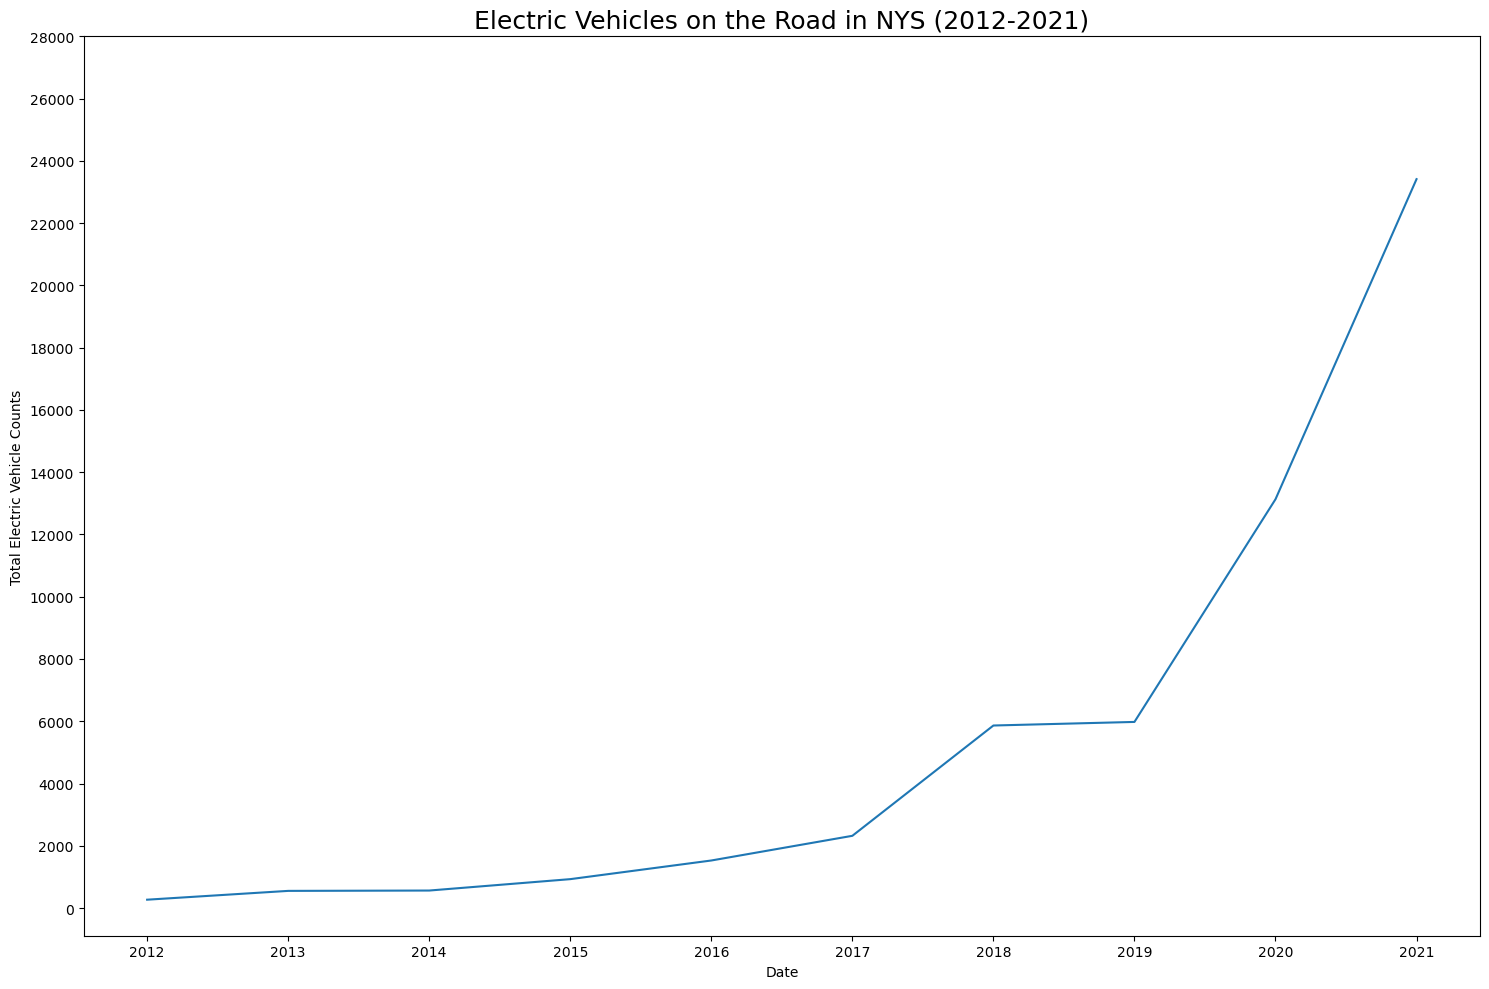

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='Year', y='Total Counts', data=Model_year_counts_df, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Electric Vehicles on the Road in NYS (2012-2021)',fontsize=18)
ax.set_xticks(range(2012,2022,1))
ax.set_yticks(range(0,30000,2000))
plt.tight_layout()
plt.savefig('Images/EV_on_the_road_2012_2021.png', facecolor='white');

### Total Electric Vehicle Count by City (Top 10)

In [38]:
City_counts_df = pd.DataFrame(City_counts)
City_counts_df= City_counts_df.reset_index()
City_counts_df.columns = ['City','Total Counts']
City_counts_df.sort_values('Total Counts',ascending = False)
City_counts_10_df= City_counts_df.head(10)
City_counts_10_df

,City,Total Counts
0,BROOKLYN,10075
1,NEW YORK,3017
2,STATEN ISLAND,1270
3,ROCHESTER,1113
4,BRONX,830
5,SCARSDALE,810
6,GREAT NECK,590
7,SYOSSET,502
8,FLUSHING,494
9,DIX HILLS,465


In [39]:
top_10_cities = ['BROOKLYN', 'NEW YORK', 'STATEN ISLAND', 'ROCHESTER', 'BRONX', 
                  'SCARSDALE', 'GREAT NECK', 'SYOSSET', 'FLUSHING', 'DIX HILLS']

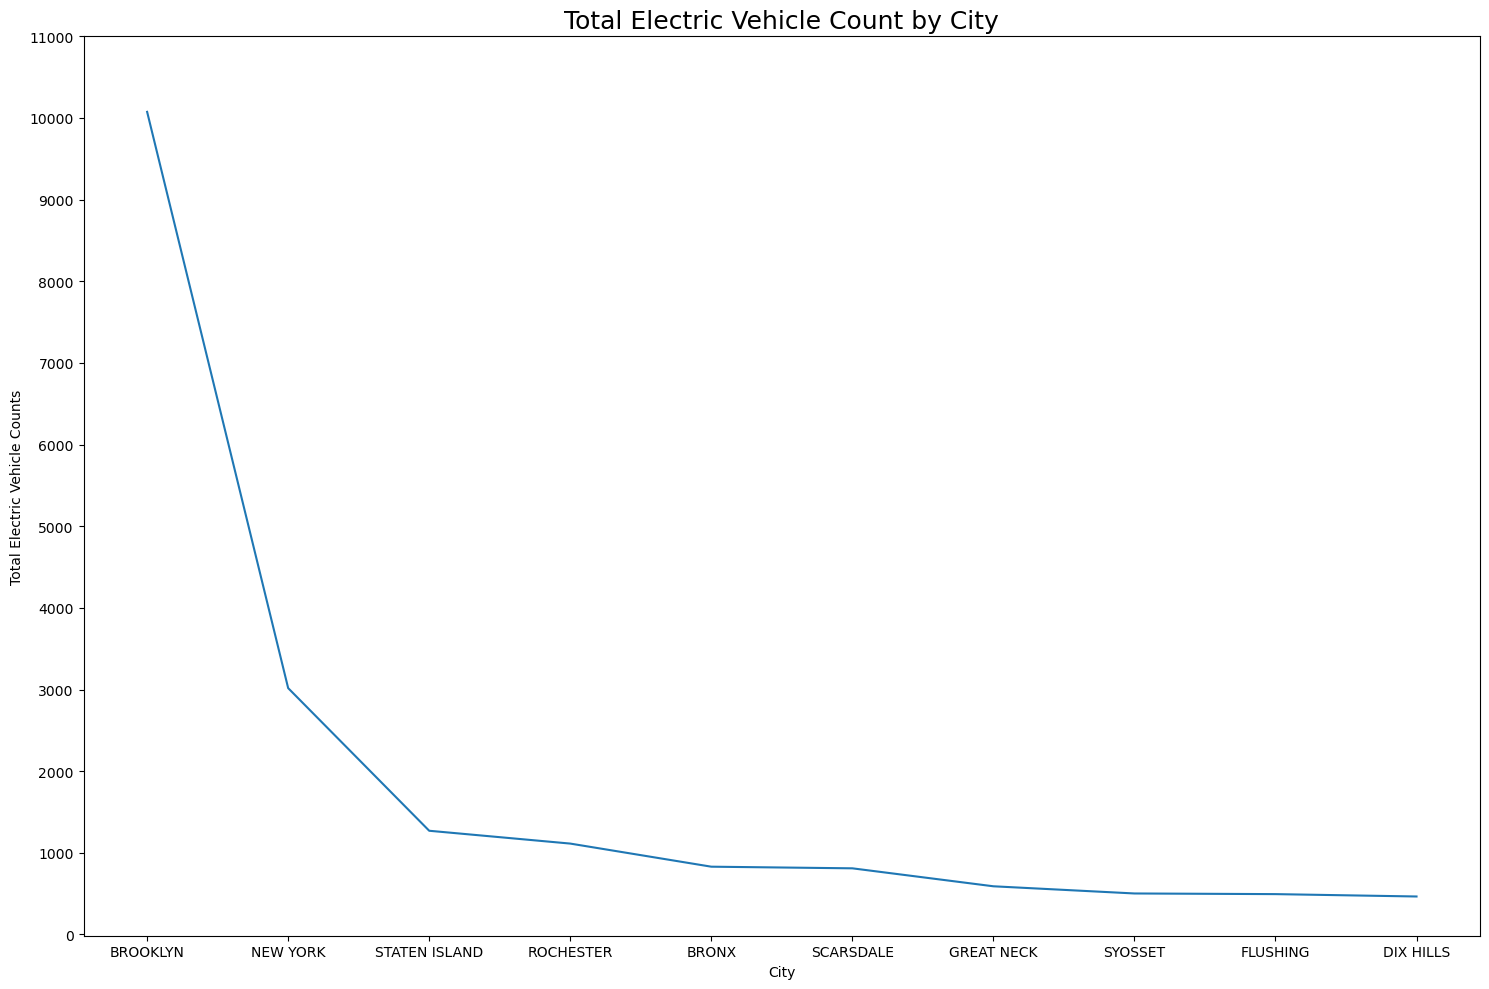

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='City', y='Total Counts', data=City_counts_10_df, ax=ax)
ax.set_xlabel('City')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Total Electric Vehicle Count by City',fontsize=18)
ax.set_yticks(range(0,12000,1000))
plt.tight_layout()
plt.savefig('Images/EV_Count_by_City.png', facecolor='white');

### Total Electric Vehicle Count by County over time (2012-2021)

In [41]:
NYS_registrations_df

,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,month/year
Reg Valid Date,,,,,,,,,,,
2014-07-01,9E2SPAXBC113501,PSD,JOHNSTOWN,NY,12095,FULTON,2012,BMW,PICK,ELECTRIC,07-2014
2021-12-09,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,TOYOTA,P/SH,ELECTRIC,12-2021
2021-11-16,9A19709,SPC,FARMINGDALE,NY,11735,SUFFOLK,2013,TOYOTA,SWT,ELECTRIC,11-2021
2021-10-19,854087,SPC,DEPEW,NY,14043,ERIE,2016,MANIT,SWT,ELECTRIC,10-2021
2021-08-11,7.85E+14,LMB,STATEN ISLAND,NY,10302,RICHMOND,2019,HONDA,MOPD,ELECTRIC,08-2021
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-24,A976B09580U,SPC,BROOKLYN,NY,11232,KINGS,2020,YALE,P/SH,ELECTRIC,01-2022
2021-10-27,A976B08198T,SPC,BROOKLYN,NY,11232,KINGS,2019,YALE,SWT,ELECTRIC,10-2021
2021-10-27,A976B07325S,SPC,BROOKLYN,NY,11232,KINGS,2018,YALE,P/SH,ELECTRIC,10-2021


In [42]:
# Count the Electric Vehicle by County in each year
NYS_registrations_2012_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2012]
NYS_registrations_by_county_2012 = NYS_registrations_2012_df.County.value_counts()

NYS_registrations_2013_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2013]
NYS_registrations_by_county_2013 = NYS_registrations_2013_df.County.value_counts()

NYS_registrations_2014_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2014]
NYS_registrations_by_county_2014 = NYS_registrations_2014_df.County.value_counts()

NYS_registrations_2015_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2015]
NYS_registrations_by_county_2015 = NYS_registrations_2015_df.County.value_counts()

NYS_registrations_2016_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2016]
NYS_registrations_by_county_2016 = NYS_registrations_2016_df.County.value_counts()

NYS_registrations_2017_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2017]
NYS_registrations_by_county_2017 = NYS_registrations_2017_df.County.value_counts()

NYS_registrations_2018_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2018]
NYS_registrations_by_county_2018 = NYS_registrations_2018_df.County.value_counts()

NYS_registrations_2019_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2019]
NYS_registrations_by_county_2019 = NYS_registrations_2019_df.County.value_counts()

NYS_registrations_2020_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2020]
NYS_registrations_by_county_2020 = NYS_registrations_2020_df.County.value_counts()

NYS_registrations_2021_df = NYS_registrations_df.loc[NYS_registrations_df['Model Year'] == 2021]
NYS_registrations_by_county_2021 = NYS_registrations_2021_df.County.value_counts()

In [43]:
# Assemble into DataFrame
NYS_registrations_by_county_df = pd.DataFrame({
             "2012": NYS_registrations_by_county_2012,
             "2013": NYS_registrations_by_county_2013,
             "2014": NYS_registrations_by_county_2014,
             "2015": NYS_registrations_by_county_2015,
             "2016": NYS_registrations_by_county_2016,
             "2017": NYS_registrations_by_county_2017,
             "2018": NYS_registrations_by_county_2018,
             "2019": NYS_registrations_by_county_2019,
             "2020": NYS_registrations_by_county_2020,
             "2021": NYS_registrations_by_county_2021})

# NYS_registrations_by_county_df = NYS_registrations_by_county_df.reset_index()

# Drop County with NA values
NYS_registrations_by_county_df = NYS_registrations_by_county_df.dropna()

# Format
NYS_registrations_by_county_df["2012"] = NYS_registrations_by_county_df["2012"].map("{:.0f}".format)
NYS_registrations_by_county_df["2013"] = NYS_registrations_by_county_df["2013"].map("{:.0f}".format)
NYS_registrations_by_county_df["2014"] = NYS_registrations_by_county_df["2014"].map("{:.0f}".format)
NYS_registrations_by_county_df["2015"] = NYS_registrations_by_county_df["2015"].map("{:.0f}".format)
NYS_registrations_by_county_df["2016"] = NYS_registrations_by_county_df["2016"].map("{:.0f}".format)
NYS_registrations_by_county_df["2017"] = NYS_registrations_by_county_df["2017"].map("{:.0f}".format)
NYS_registrations_by_county_df["2018"] = NYS_registrations_by_county_df["2018"].map("{:.0f}".format)
NYS_registrations_by_county_df["2019"] = NYS_registrations_by_county_df["2019"].map("{:.0f}".format)
NYS_registrations_by_county_df["2020"] = NYS_registrations_by_county_df["2020"].map("{:.0f}".format)
NYS_registrations_by_county_df["2021"] = NYS_registrations_by_county_df["2021"].map("{:.0f}".format)

NYS_registrations_by_county_df

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ALBANY,5,18,15,23,57,61,115,142,181,276
BRONX,5,4,23,13,22,32,68,91,122,367
BROOME,5,5,11,13,10,32,27,30,46,76
CHAUTAUQUA,2,2,2,3,3,13,8,26,19,33
CLINTON,2,4,2,2,6,6,9,18,17,34
DUTCHESS,9,14,9,23,32,70,121,152,188,409
ERIE,10,22,15,37,38,94,196,253,350,691
ESSEX,1,2,2,1,3,6,7,13,17,26
KINGS,9,31,36,41,84,90,331,327,3793,5122
MONROE,25,30,38,65,59,122,239,328,487,781


In [44]:
# Too many counties, select the top 10 counties based on the registrations number in 2021 
NYS_registrations_by_county_df = NYS_registrations_by_county_df.astype(int)
NYS_registrations_by_county_10_df = NYS_registrations_by_county_df.sort_values(['2021'],ascending = False).head(10).T
NYS_registrations_by_county_10_df

,KINGS,NASSAU,SUFFOLK,WESTCHESTER,QUEENS,NEW YORK,MONROE,ERIE,RICHMOND,ROCKLAND
2012,9,17,32,23,14,8,25,10,1,5
2013,31,52,60,72,60,41,30,22,6,13
2014,36,55,68,68,33,66,38,15,7,10
2015,41,108,90,131,42,89,65,37,11,19
2016,84,192,191,213,105,228,59,38,25,24
2017,90,286,256,298,159,195,122,94,46,46
2018,331,999,782,925,421,428,239,196,96,158
2019,327,843,768,838,420,353,328,253,123,117
2020,3793,1607,1426,1300,648,861,487,350,214,281
2021,5122,3391,2898,2538,1555,1125,781,691,565,512


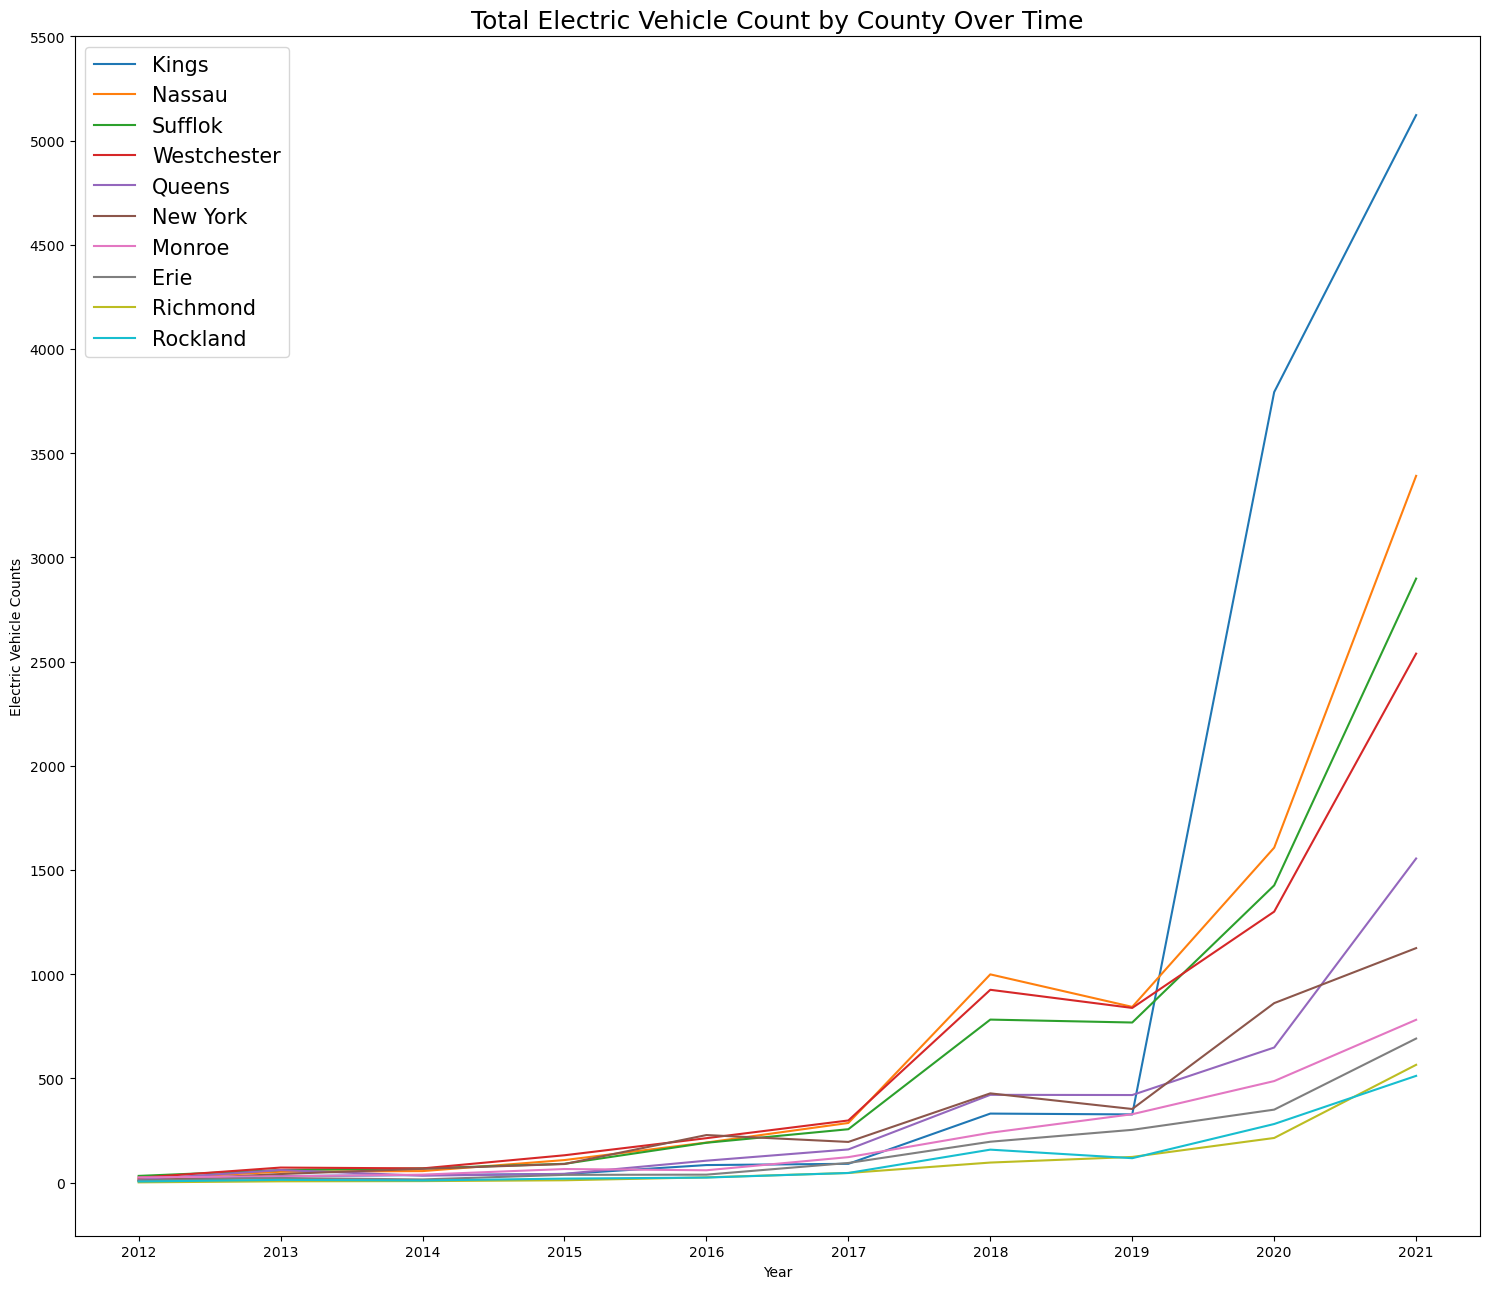

In [45]:
fig, ax = plt.subplots(figsize=(15,13))
ax.plot(NYS_registrations_by_county_10_df['KINGS'],label='Kings')
ax.plot(NYS_registrations_by_county_10_df['NASSAU'],label='Nassau')
ax.plot(NYS_registrations_by_county_10_df['SUFFOLK'],label='Sufflok')
ax.plot(NYS_registrations_by_county_10_df['WESTCHESTER'],label='Westchester')
ax.plot(NYS_registrations_by_county_10_df['QUEENS'],label='Queens')
ax.plot(NYS_registrations_by_county_10_df['NEW YORK'],label='New York')
ax.plot(NYS_registrations_by_county_10_df['MONROE'],label='Monroe')
ax.plot(NYS_registrations_by_county_10_df['ERIE'],label='Erie')
ax.plot(NYS_registrations_by_county_10_df['RICHMOND'],label='Richmond')
ax.plot(NYS_registrations_by_county_10_df['ROCKLAND'],label='Rockland')

ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Counts')
ax.set_title('Total Electric Vehicle Count by County Over Time',fontsize=18)
ax.set_yticks(range(0,6000,500))
ax.legend(fontsize=15)
plt.tight_layout()
plt.savefig('Images/EV_Count_by_County_Over_Time.png', facecolor='white');

## Most Purchased Car Models by County

In [46]:
County_counts_df = pd.DataFrame(County_counts)
County_counts_df = County_counts_df.reset_index()
County_counts_df.columns = ['County','Total Counts']
County_counts_df.sort_values('Total Counts',ascending = False)
County_counts_10_df= County_counts_df.head(10)
County_counts_10_df

,County,Total Counts
0,KINGS,10212
1,NASSAU,8531
2,SUFFOLK,7369
3,WESTCHESTER,7170
4,QUEENS,3883
5,NEW YORK,3664
6,MONROE,2376
7,ERIE,1873
8,ROCKLAND,1346
9,RICHMOND,1270


In [47]:
# Top 10 County
top_10_county = ['KINGS', 'NASSAU','SUFFOLK','WESTCHESTER','QUEENS','NEW YORK','MONROE','ERIE','ROCKLAND','RICHMOND']


### Most Purchased Models in King County (Top 6)

In [48]:
County_model_counts_df=NYS_registrations_df[['County','Model Year','Make']]
County_model_counts_df.head()

,County,Model Year,Make
Reg Valid Date,,,
2014-07-01,FULTON,2012,BMW
2021-12-09,KINGS,2014,TOYOTA
2021-11-16,SUFFOLK,2013,TOYOTA
2021-10-19,ERIE,2016,MANIT
2021-08-11,RICHMOND,2019,HONDA


In [49]:
Kings_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'KINGS')]
Kings_model_counts = Kings_counts_df.Make.value_counts()
Kings_model_counts

NIU              6877
TESLA            2679
CHEVROLET         122
HYUNDAI            99
NISSAN             59
SMART              59
FORD               41
AUDI               38
VOLKSWAGEN         32
BMW                30
KIA                28
HINO               18
INTERNATIONAL      15
PORSCHE            14
ZERO EV            12
YALE               10
POLESTAR            8
VOLVO               8
MINI                7
NEW FLYER           6
GENESIS             5
PIAGGIO             4
TOYOTA              4
FIAT                3
HONDA               3
ICBUS               2
CRUS                2
RIVIAN              2
JAGUAR              2
CUSTO               2
GENZE               2
GEM                 1
DOOSA               1
AMPER               1
SUBARU              1
ALTA                1
GE/SC               1
AZURE               1
ETUK                1
JIAJ                1
LUCID               1
HA/DA               1
BAODI               1
CY/TR               1
FLYWI               1
MITSUBISHI

In [50]:
Kings_model_counts_df = pd.DataFrame(Kings_model_counts)
Kings_model_counts_6_df = Kings_model_counts_df .reset_index().head(6)
Kings_model_counts_6_df.columns = ['Model','Total Counts']
Kings_model_counts_6_df

,Model,Total Counts
0,NIU,6877
1,TESLA,2679
2,CHEVROLET,122
3,HYUNDAI,99
4,NISSAN,59
5,SMART,59


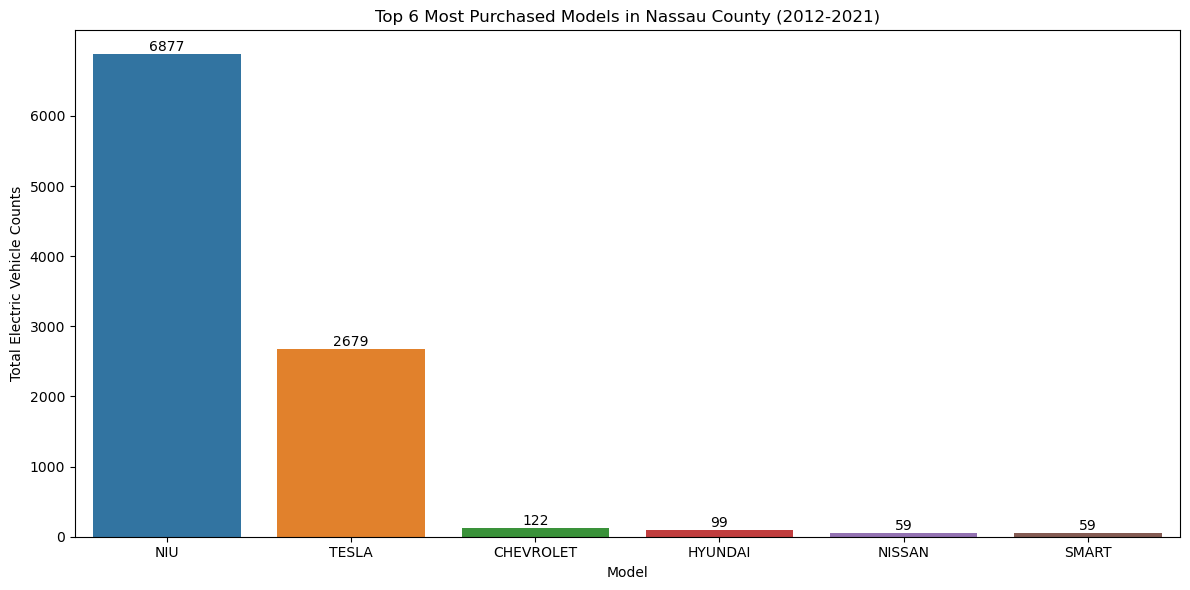

In [51]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Kings_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Nassau County (2012-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_King.png', facecolor='white');

### Most Purchased Models in Nassau County (Top 6)

In [52]:
Nassau_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'NASSAU')]
Nassau_model_counts = Nassau_counts_df.Make.value_counts()
#Nassau_model_counts

In [53]:
Nassau_model_counts_df = pd.DataFrame(Nassau_model_counts)
Nassau_model_counts_6_df = Nassau_model_counts_df .reset_index().head(6)
Nassau_model_counts_6_df.columns = ['Model','Total Counts']
Nassau_model_counts_6_df

,Model,Total Counts
0,TESLA,6908
1,HYUNDAI,453
2,FORD,231
3,PORSCHE,176
4,CHEVROLET,168
5,AUDI,129


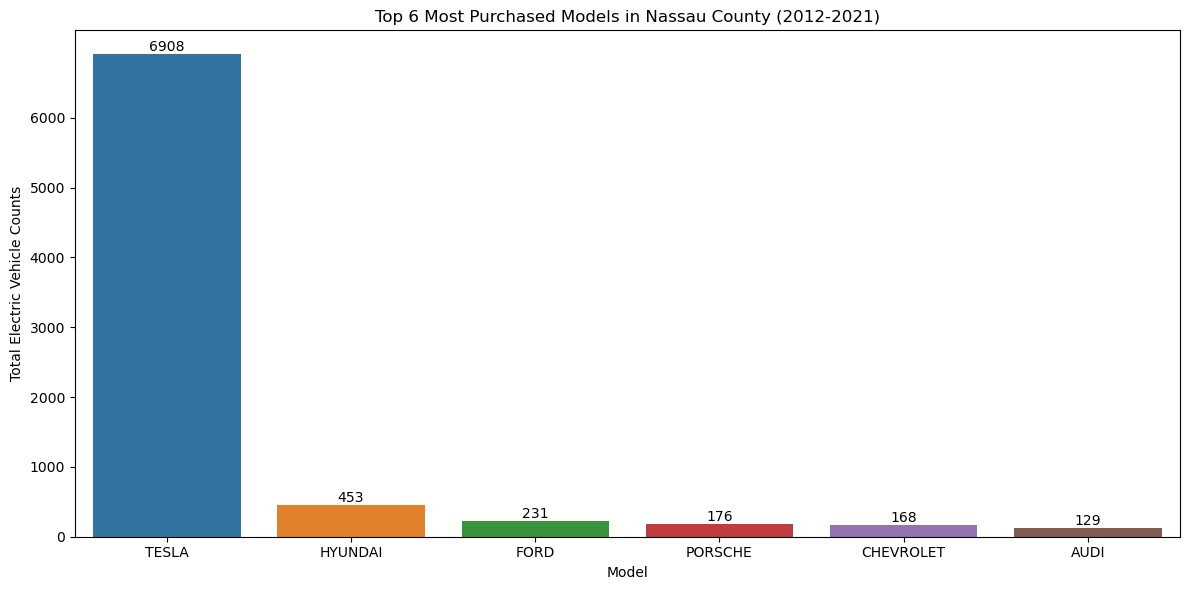

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Nassau_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Nassau County (2012-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Nassau.png', facecolor='white');

### Most Purchased Models in Suffolk County (Top 6)

In [55]:
Suffolk_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'SUFFOLK')]
Suffolk_model_counts = Suffolk_counts_df.Make.value_counts()
#Suffolk_model_counts

In [56]:
Suffolk_model_counts_df = pd.DataFrame(Suffolk_model_counts)
Suffolk_model_counts_6_df = Suffolk_model_counts_df .reset_index().head(6)
Suffolk_model_counts_6_df.columns = ['Model','Total Counts']
Suffolk_model_counts_6_df

,Model,Total Counts
0,TESLA,5572
1,HYUNDAI,466
2,CHEVROLET,239
3,FORD,239
4,NISSAN,175
5,PORSCHE,102


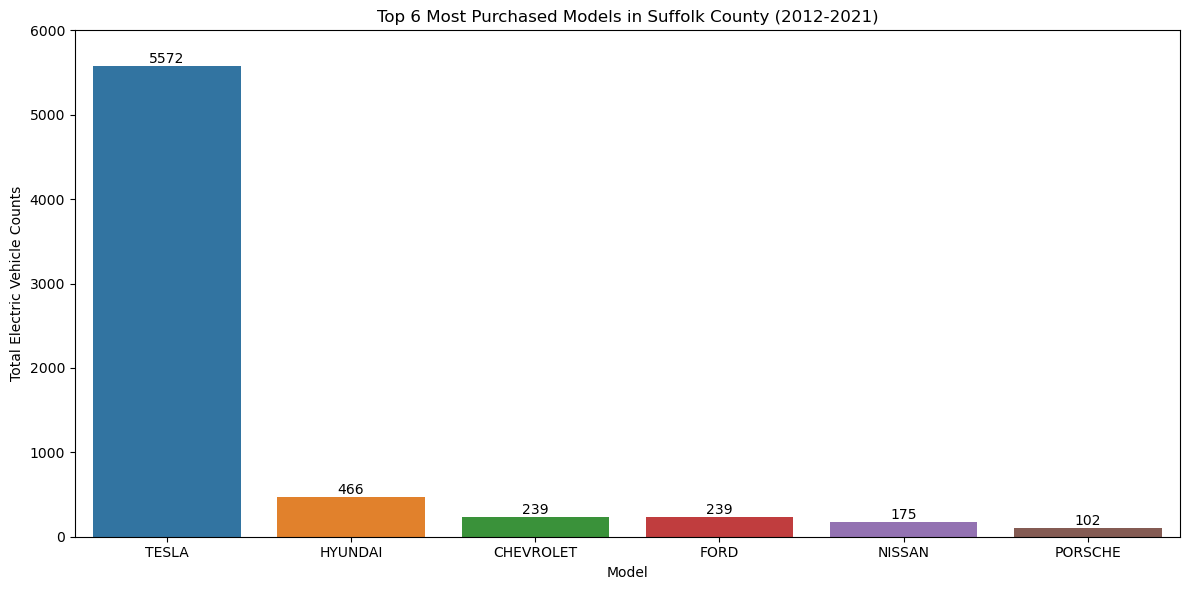

In [57]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Suffolk_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Suffolk County (2012-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Suffolk.png', facecolor='white');

### Most Purchased Models in Westchester County (Top 6)

In [58]:
Westchester_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'WESTCHESTER')]
Westchester_model_counts = Westchester_counts_df.Make.value_counts()
#Westchester_model_counts

In [59]:
Westchester_model_counts_df = pd.DataFrame(Westchester_model_counts)
Westchester_model_counts_6_df = Westchester_model_counts_df .reset_index().head(6)
Westchester_model_counts_6_df.columns = ['Model','Total Counts']
Westchester_model_counts_6_df

,Model,Total Counts
0,TESLA,5628
1,CHEVROLET,255
2,NISSAN,201
3,HYUNDAI,179
4,FORD,168
5,AUDI,137


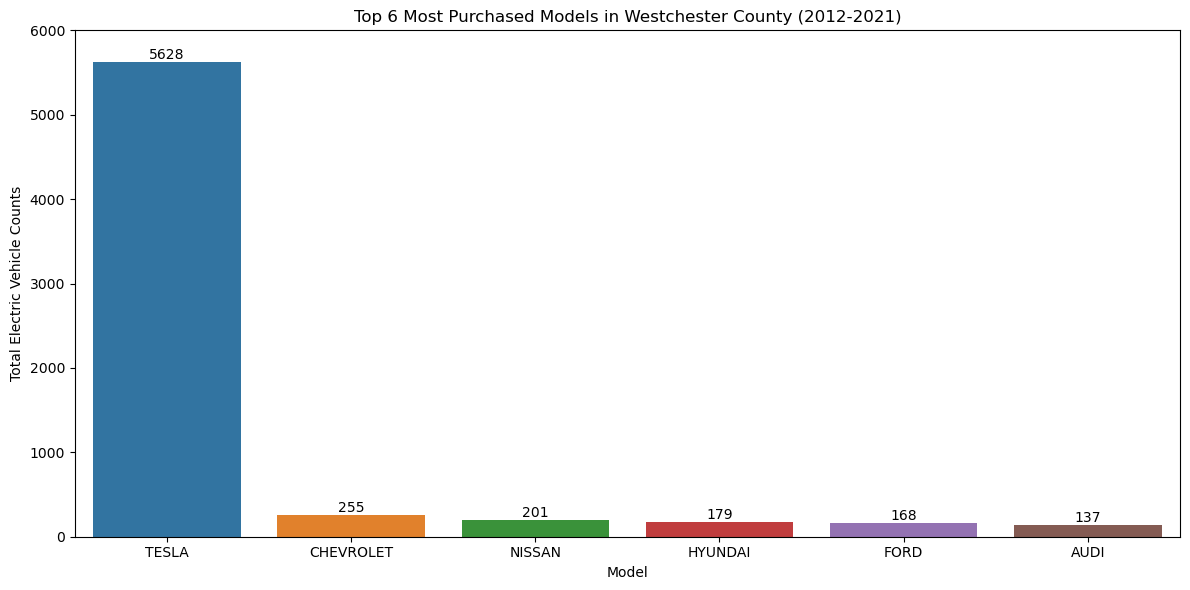

In [60]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Westchester_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Westchester County (2012-2021)')
ax.set_yticks(range(0,7000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Westchester.png', facecolor='white');

### Most Purchased Models in Queens County (Top 6)

In [61]:
Queens_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'QUEENS')]
Queens_model_counts = Queens_counts_df.Make.value_counts()
#Queens_model_counts

In [62]:
Queens_model_counts_df = pd.DataFrame(Queens_model_counts)
Queens_model_counts_6_df = Queens_model_counts_df .reset_index().head(6)
Queens_model_counts_6_df.columns = ['Model','Total Counts']
Queens_model_counts_6_df

,Model,Total Counts
0,TESLA,2967
1,CHEVROLET,249
2,NISSAN,148
3,HYUNDAI,130
4,FORD,95
5,KIA,56


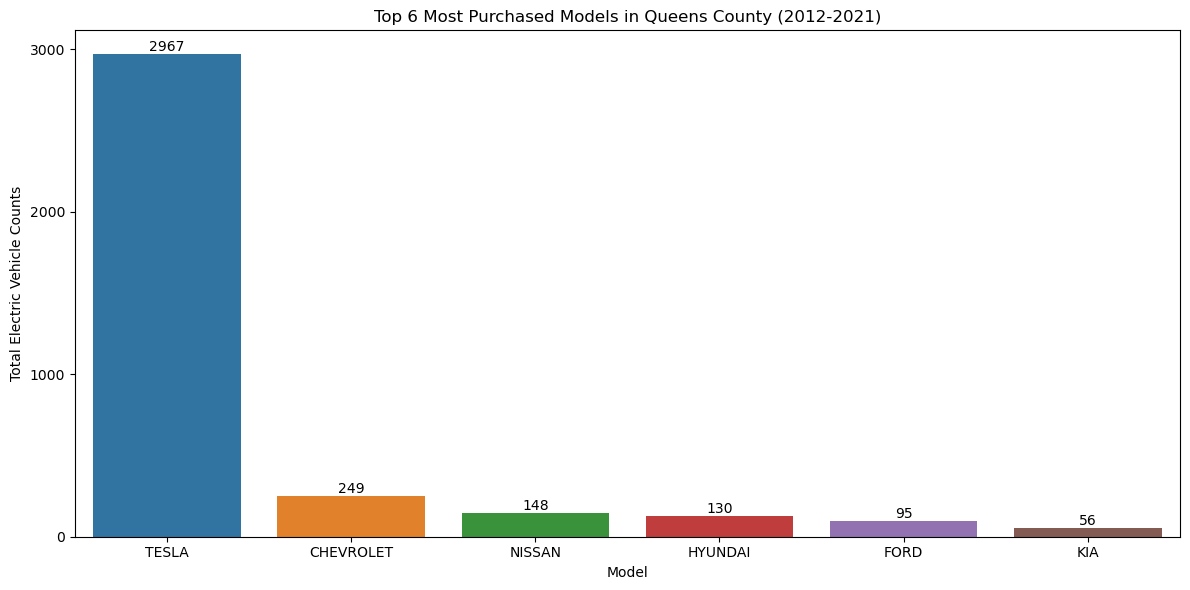

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Queens_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Queens County (2012-2021)')
ax.set_yticks(range(0,4000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Queens.png', facecolor='white');

### Most Purchased Models in New York County (Top 6)

In [64]:
New_York_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'NEW YORK')]
New_York_model_counts = New_York_counts_df.Make.value_counts()
#New_York_model_counts

In [65]:
New_York_model_counts_df = pd.DataFrame(New_York_model_counts)
New_York_model_counts_6_df = New_York_model_counts_df.reset_index().head(6)
New_York_model_counts_6_df.columns = ['Model','Total Counts']
New_York_model_counts_6_df

,Model,Total Counts
0,TESLA,2714
1,CHEVROLET,218
2,NISSAN,182
3,EL/SM,77
4,PORSCHE,70
5,AUDI,55


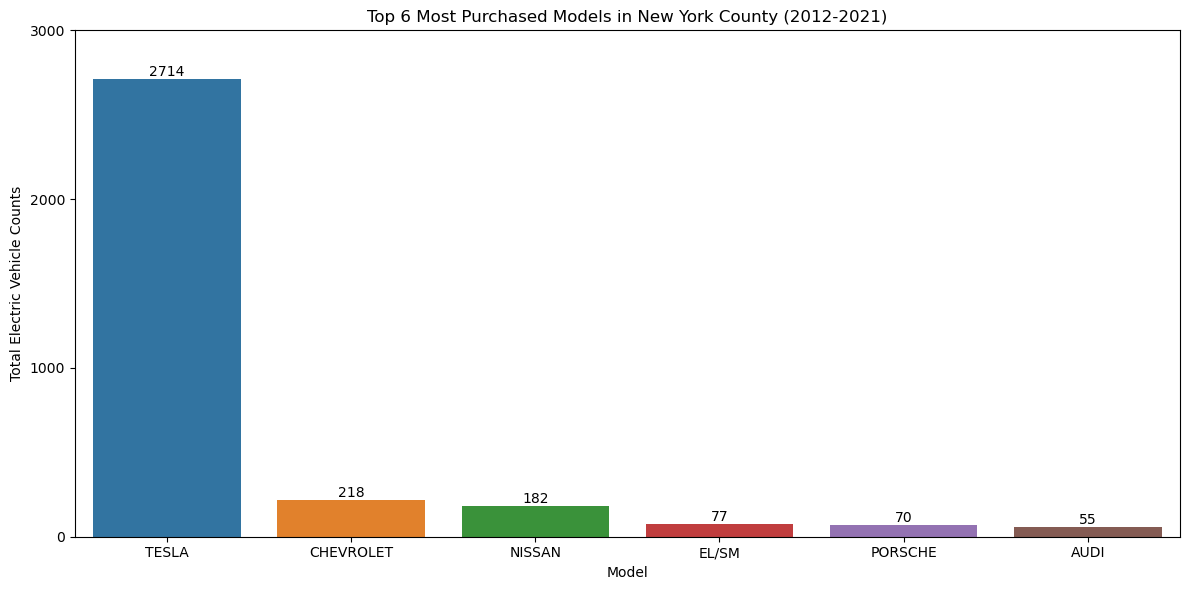

In [66]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=New_York_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in New York County (2012-2021)')
ax.set_yticks(range(0,4000,1000))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_New_York.png', facecolor='white');

### Most Purchased Models in Monroe County (Top 6)

In [67]:
Monroe_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'MONROE')]
Monroe_model_counts = Monroe_counts_df.Make.value_counts()
#Monroe_model_counts

In [68]:
Monroe_model_counts_df = pd.DataFrame(Monroe_model_counts)
Monroe_model_counts_6_df = Monroe_model_counts_df.reset_index().head(6)
Monroe_model_counts_6_df.columns = ['Model','Total Counts']
Monroe_model_counts_6_df

,Model,Total Counts
0,TESLA,1101
1,CHEVROLET,338
2,NISSAN,265
3,HYUNDAI,247
4,FORD,89
5,KIA,88


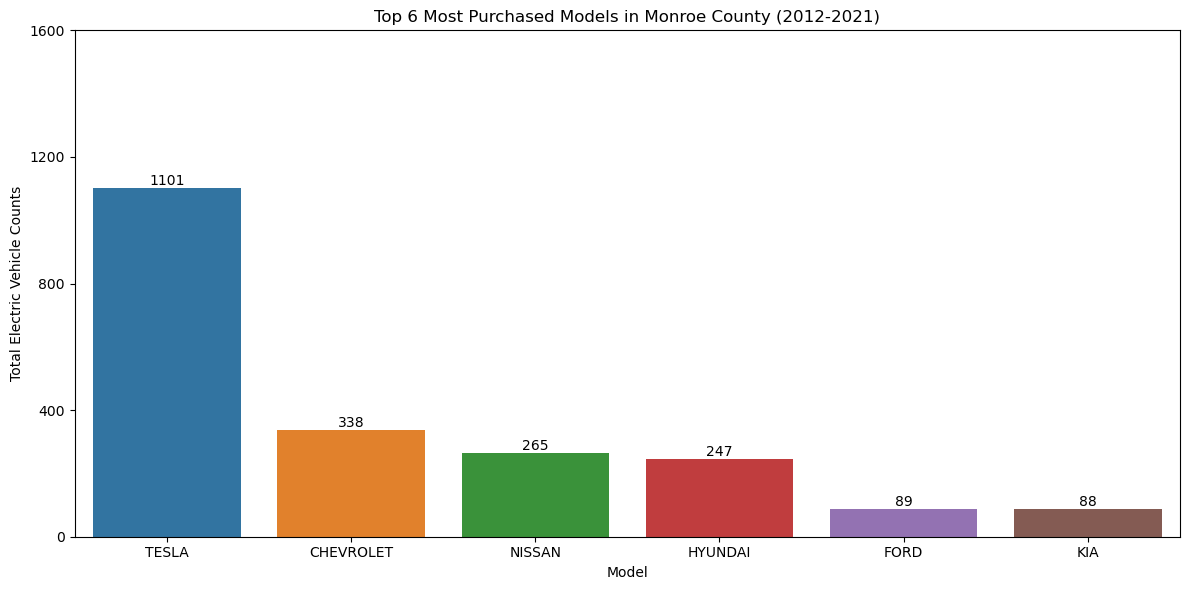

In [69]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Monroe_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Models in Monroe County (2012-2021)')
ax.set_yticks(range(0,2000,400))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Monroe.png', facecolor='white');

### Most Purchased Models in Erie County (Top 6)

In [70]:
Erie_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'ERIE')]
Erie_model_counts = Erie_counts_df.Make.value_counts()
#Erie_model_counts

In [71]:
Erie_model_counts_df = pd.DataFrame(Erie_model_counts)
Erie_model_counts_6_df = Erie_model_counts_df.reset_index().head(6)
Erie_model_counts_6_df.columns = ['Model','Total Counts']
Erie_model_counts_6_df

,Model,Total Counts
0,TESLA,902
1,HYUNDAI,321
2,CHEVROLET,194
3,FORD,124
4,NISSAN,119
5,VOLKSWAGEN,38


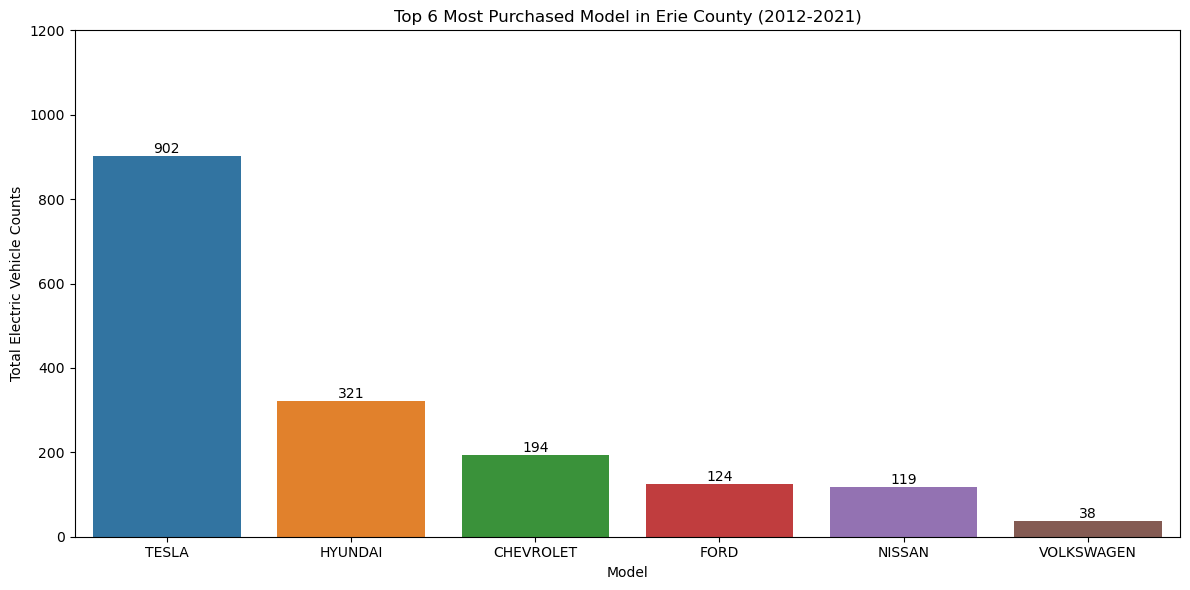

In [72]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Erie_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Model in Erie County (2012-2021)')
ax.set_yticks(range(0,1400,200))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Erie.png', facecolor='white');

### Most Purchased Models in Rockland County (Top 6)

In [73]:
Rockland_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'ROCKLAND')]
Rockland_model_counts = Rockland_counts_df.Make.value_counts()
#Rockland_model_counts

In [74]:
Rockland_model_counts_df = pd.DataFrame(Rockland_model_counts)
Rockland_model_counts_6_df = Rockland_model_counts_df.reset_index().head(6)
Rockland_model_counts_6_df.columns = ['Model','Total Counts']
Rockland_model_counts_6_df

,Model,Total Counts
0,TESLA,992
1,HYUNDAI,113
2,FORD,52
3,CHEVROLET,43
4,NISSAN,42
5,KIA,21


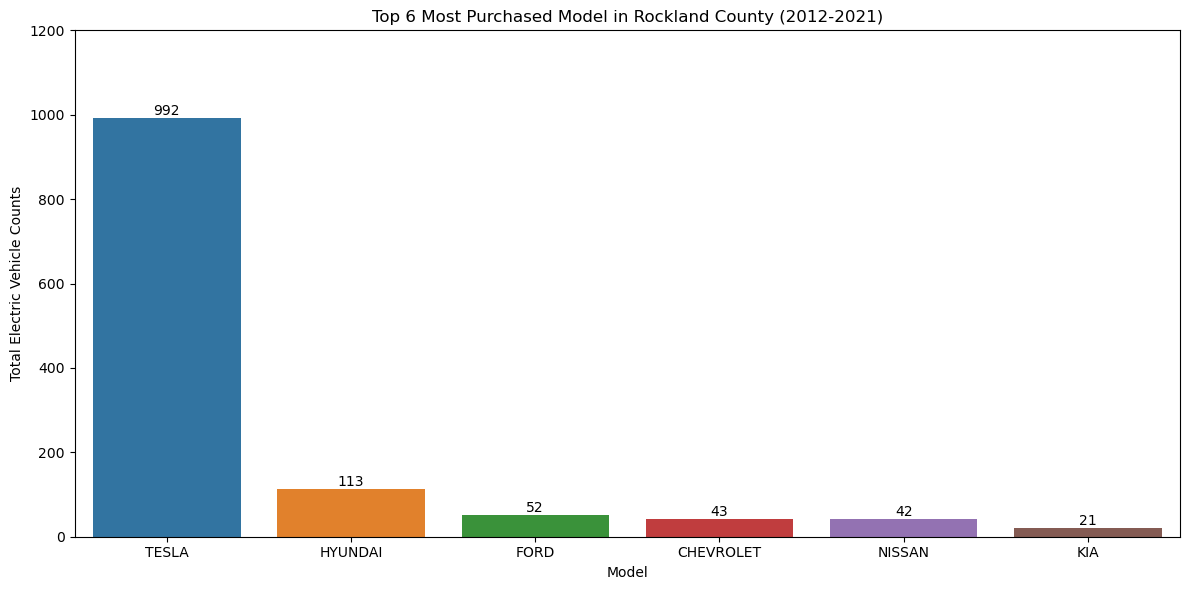

In [75]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Rockland_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Model in Rockland County (2012-2021)')
ax.set_yticks(range(0,1400,200))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Rockland.png', facecolor='white');

### Most Purchased Models in Richmond County (Top 6)

In [76]:
Richmond_counts_df = County_model_counts_df.loc[(County_model_counts_df['County'] == 'RICHMOND')]
Richmond_model_counts = Richmond_counts_df.Make.value_counts()
#Richmond_model_counts

In [77]:
Richmond_model_counts_df = pd.DataFrame(Richmond_model_counts)
Richmond_model_counts_6_df = Richmond_model_counts_df.reset_index().head(6)
Richmond_model_counts_6_df.columns = ['Model','Total Counts']
Richmond_model_counts_6_df

,Model,Total Counts
0,TESLA,961
1,HYUNDAI,94
2,FORD,51
3,NISSAN,26
4,CHEVROLET,25
5,PORSCHE,17


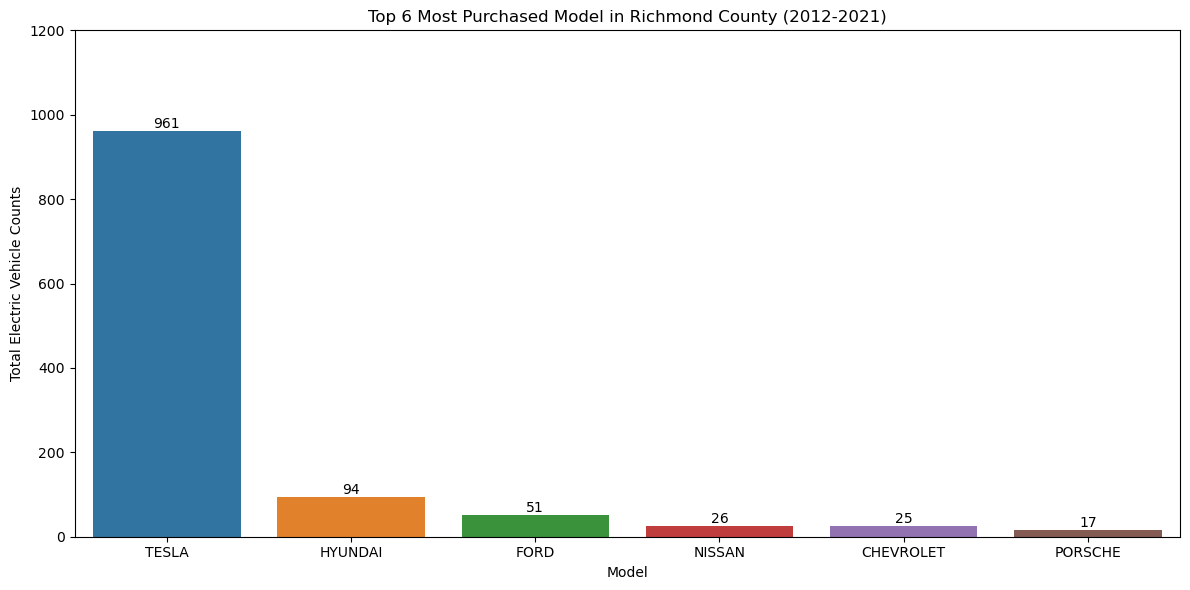

In [78]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='Model', y='Total Counts', data=Richmond_model_counts_6_df, ax=ax)
ax.set_xlabel('Model')
ax.set_ylabel('Total Electric Vehicle Counts')
ax.set_title('Top 6 Most Purchased Model in Richmond County (2012-2021)')
ax.set_yticks(range(0,1400,200))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.savefig('Images/EV_Model_Count_in_Richmond.png', facecolor='white');

# MODEL

## Preprocessing/ Defining Functions

In [79]:
df_cumsum = df_cumsum.set_index('Reg Valid Date').resample('M').asfreq()

In [80]:
df_cumsum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2014-04-30 to 2022-02-28
Freq: M
Data columns (total 64 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FULTON        95 non-null     float64
 1   KINGS         95 non-null     float64
 2   SUFFOLK       95 non-null     float64
 3   ERIE          95 non-null     float64
 4   RICHMOND      95 non-null     float64
 5   NASSAU        95 non-null     float64
 6   ROCKLAND      95 non-null     float64
 7   QUEENS        95 non-null     float64
 8   WESTCHESTER   95 non-null     float64
 9   SARATOGA      95 non-null     float64
 10  NEW YORK      95 non-null     float64
 11  BRONX         95 non-null     float64
 12  STEUBEN       95 non-null     float64
 13  ONTARIO       95 non-null     float64
 14  OSWEGO        95 non-null     float64
 15  RENSSELAER    95 non-null     float64
 16  MONROE        95 non-null     float64
 17  ORANGE        95 non-null     float64
 18  ONON

### Separating Data for Each County
As discussed above, we will be creating time series models for the top ten counties. This requires us to break down the dataframe we have into smaller dataframes for each county.

In [81]:
def separate_data_by_county(county, df):
    """Function separates the given dataframe by county and returns the 
    separated dataframe.
    -------------------------------
    Arguments:
    county: str
    Name of county that will be separated from the dataframe. 
    
    df: class: pandas.DataFrame
    Dataframe that contains data for all counties. The specified county will 
    be separated from this DataFrame. 
    """
    
    df_county = pd.DataFrame(df.loc[:, county])
    df_county.columns=["EV's on the Road"]
    df_county.head()
    return df_county

In [82]:
#separating data by county and parsing this information to a dictionary
county_information = {}
for county in top_10_county:
    county_information[county] = {}
    county_information[county]['df']=separate_data_by_county(county, df_cumsum)

In [83]:
#separating data by county and parsing this information to a dictionary
county_dfs = {}
for county in top_10_county:
    county_dfs[county] = separate_data_by_county(county, df_cumsum)

### Functionizing the Evaluation of Models
Before modelling, one of the functions we will need is a function that will show us the various statistics so that we can evaluate the performance of the model.

In [84]:
def evaluate_model(model):
    """Function returns the model summary and diagnostics information to aid 
    the evaluation of the given model's performance.
    -------------------------------
    Arguments:
    model: SARIMAX or ARIMA model object
    Model variable to evaluate (Time series models for both pmdarima and 
    statsmodels are supported. 
    """
    
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout();

### Creating a Function for train_test_split & plotting
We will be splitting the time series into two: a training set and a testing set. This will allow us to validate the performance of the models.

In [85]:
def train_test_split_ts (df, train_size, test_size):
    
    """Function splits a given DataFrame into two sets based on the given 
    train and test sizes so that the data can be used for validation.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame
    The base dataframe that will be getting split.
    
    train_size: float
    The size of the desired training set (for example: 0.80)
    
    test_size: float
    The size of the desired training set (for example: 0.20)
    """
    
    train_end_idx = int(round(len(df)*train_size,0))
    train_set = df.iloc[0:train_end_idx,:]["EV's on the Road"]
    test_set = df.iloc[train_end_idx:,:]["EV's on the Road"]
    return train_set, test_set

Additionally, to visualize these splits we will need a plotting function.

In [86]:
def plot_train_test_split(train_data, test_data, county):
    
    """Function plots the training and testing data for visual inspection.
    -------------------------------
    Arguments:
    train_data: pandas.Series
    The training set of data to be plotted.
    
    test_data: pandas.Series
    The test set of data to be plotted.
    
    county: str
    Name of the county that the training and testing data belongs to. This 
    string is used to set the title of the axes.
    """
    
    train_data.plot(label='Train Data')
    test_data.plot(label='Test Data')
    ax=plt.gca()
    ax.set_xlabel('Year')
    ax.set_ylabel('Electric Vehicles on the Road')
    ax.set_title(f'Electric Vehicles on the Road in {county} County')
    ax.legend();

### Creating a Function for Getting Forecasts
For validation purposes we will be getting the forecast from our model for the test period and will be plotting it against the actual test data.

In [87]:
def get_forecast(model, train_data, test_data, plot=True):
    
    """Function gets forecasted values from a given model and plots them for 
    visual inspection. The length of the forecasts are dependent on the length 
    of the test data. The forecasted values are returned in a DataFrame format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model that the forecast is to be received from. 
    
    train_data: pandas.Series
    The training set of data used in training the model.
    
    test_data: pandas.Series
    The testing set of data used for validating the model.
    
    plot: bool, default=True
    Option to plot the forecasted values along with observed values 
    (train_data and test_data).
    """
    
    #creating a df with the forecast information
    forecast_df = model.get_forecast(steps=len(test_data)).conf_int()
    forecast_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    forecast_df['Forecasts'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=train_data, color='black', ax=ax)
            sns.lineplot(data=forecast_df, x=forecast_df.index, 
                         y='Forecasts', color='blue', ax=ax, 
                         label='Forecasted Data', ls='--')
            sns.lineplot(data=test_data, color='purple', ax=ax, 
                         label='Actual Data', ls='-.')
            ax.fill_between(forecast_df.index, 
                            y1=forecast_df['Lower Confidence Interval'], 
                            y2=forecast_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.legend(loc=2)
            plt.show();
    return forecast_df

### Defining a Function for Getting Predictions for Future
Lastly, we will also be needing a function similar to the get_forecast function that will be used for getting predictions for the future and plotting for visualization.

In [88]:
def get_prediction(model, df, test_data, county_name, plot=True):
    
    """Function gets predicted values from a given model and plots them for 
    visual inspection. The length of the predictions are dependent on the 
    length of the test data. The forecasted values are returned in a DataFrame 
    format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model to be used for making predictions.
    
    df: pandas.DataFrame
    DataFrame that contains all observed data.
    
    test_data: pandas.Series
    The testing set of data used for validating the model (dictates the length
    of predictions).
    
    plot: bool, default=True
    Option to plot the predicted values along with observed values.
    """
    
    #creating a df with the prediction information
    prediction_df = model.get_forecast(steps=len(test_data)).conf_int()
    prediction_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    prediction_df['Predictions'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=df, ax=ax)
            sns.lineplot(data=prediction_df, x=prediction_df.index, 
                         y='Predictions', color='orange', ax=ax, 
                         label='Predicted Data', ls='--')
            ax.fill_between(prediction_df.index, 
                            y1=prediction_df['Lower Confidence Interval'], 
                            y2=prediction_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.set_ylabel('Electric Vehicles on the Road')
            ax.set_title(f'Predicted Electric Vehicle Count for {county_name}')
            plt.show();
    return prediction_df

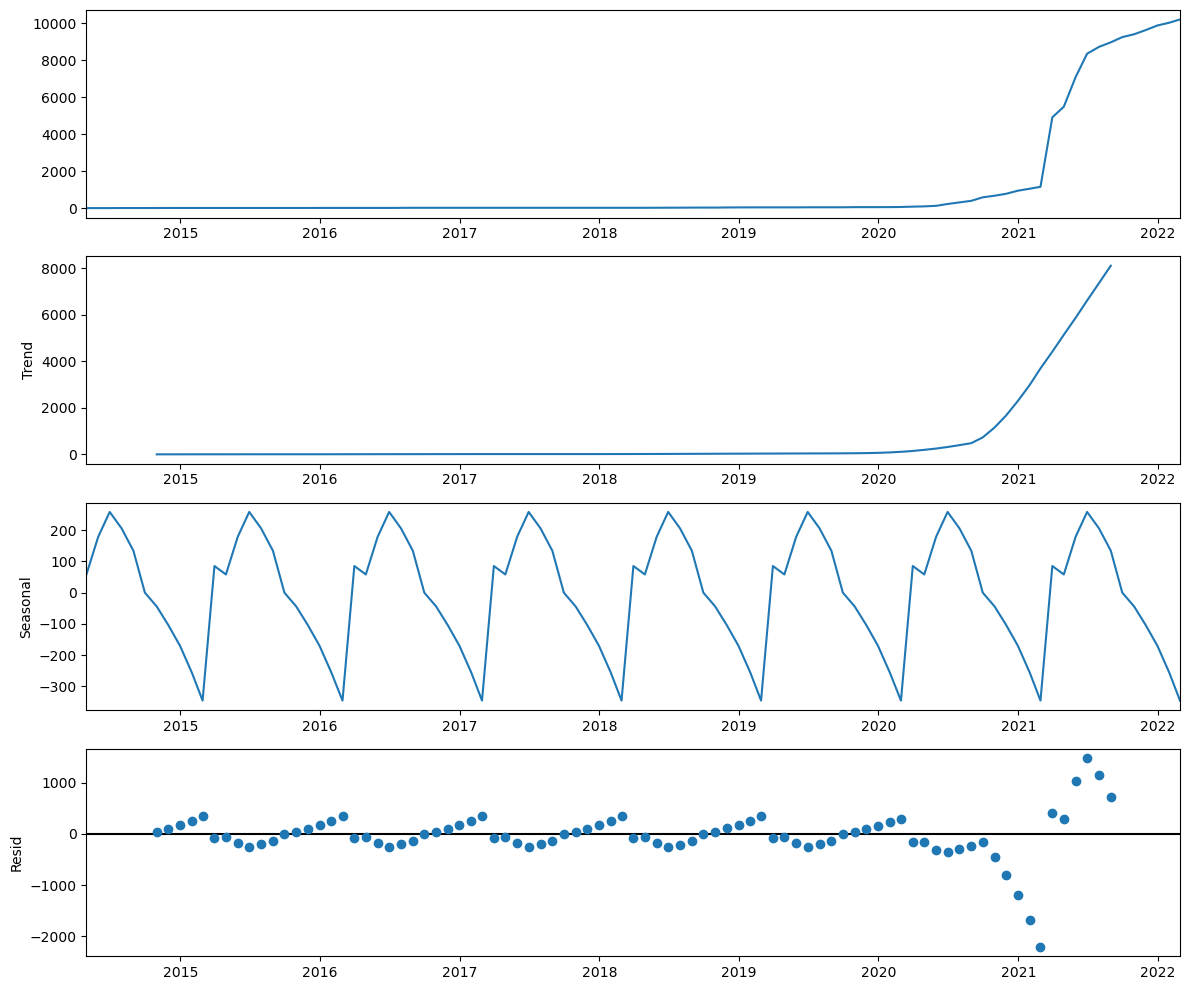

In [89]:
import statsmodels.tsa.api as tsa

plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['KINGS']['df'])
decomp.plot();

Not surprisingly, the electric vehicle count for King County has an upward trend. Additionally, we can see that there is seasonality to the data as well. We can now move onto creating the training and testing sets for validation.

### train_test_split
After multiple iterations, we found that the 0.80-0.20 split of the data belonging to King County resulted in the best performance.

In [98]:
#splitting dataset into train and test sets for validation
train_KINGS, test_KINGS = train_test_split_ts(county_information['KINGS']['df'], 
                                            0.80, 0.20)

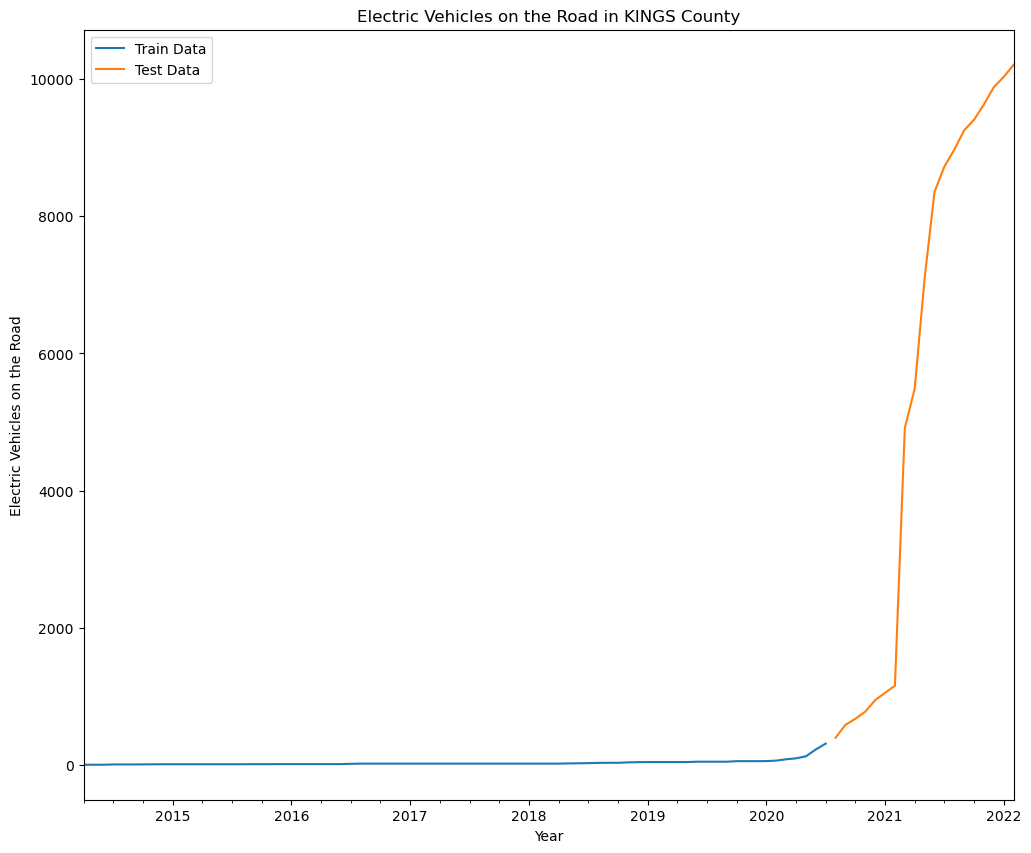

In [99]:
#plotting the split
plot_train_test_split(train_KINGS, test_KINGS, 'KINGS')

### Finding Best Parameters with Auto-Arima

To have a model that can accurately predict future values, we need to optimize the p,d,q values of the models for each county and validate. In order to achieve this programmatically, we will be using the pmdarima library.

In [95]:
import pmdarima as pm

In [100]:
auto_model = pm.auto_arima(train_KINGS, start_p=0, d=1, start_q=0, max_p=4, 
                           max_d=3, max_q=4, start_P=0, start_Q=0, max_P=3, 
                           max_D=3, max_Q=3, m=12)
auto_model.summary()

/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sar

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(0, 2, [], 12)   Log Likelihood                -190.461
Date:                             Wed, 16 Nov 2022   AIC                            386.922
Time:                                     19:29:20   BIC                            392.717
Sample:                                 04-30-2014   HQIC                           389.136
                                      - 07-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8133      0.178      4.564      0.000       0.464       1.163
ma.L1          0.4536      0.212      2.142      0.032       0.039       0.869
sigma2        98.7924     12.885      7.667      0.000      73.539     124.046
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               453.42
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):              20.78   Skew:                             2.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (1,1,1) for the ARIMA order and (0, 2, [], 12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

In [101]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37990D+00    |proj g|=  3.09093D-02

At iterate    5    f=  2.37842D+00    |proj g|=  1.29544D-03

At iterate   10    f=  2.37836D+00    |proj g|=  2.16183D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   2.162D-06   2.378D+00
  F =   2.3783563221384045     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                   76
Model:             SARIMAX(1, 1, 1)x(0, 2, [], 12)   Log Likelihood                -180.755
Date:                             Wed, 16 Nov 2022   AIC                            367.510
Time:                                     19:33:57   BIC                            373.186
Sample:                                 04-30-2014   HQIC                           369.663
                                      - 07-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3796      0.117     11.766      0.000       1.150       1.609
ma.L1         -0.4619      0.218     -2.120      0.034      -0.889      -0.035
sigma2        93.5899     11.901      7.864      0.000      70.265     116.914
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               365.20
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              12.35   Skew:                             2.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

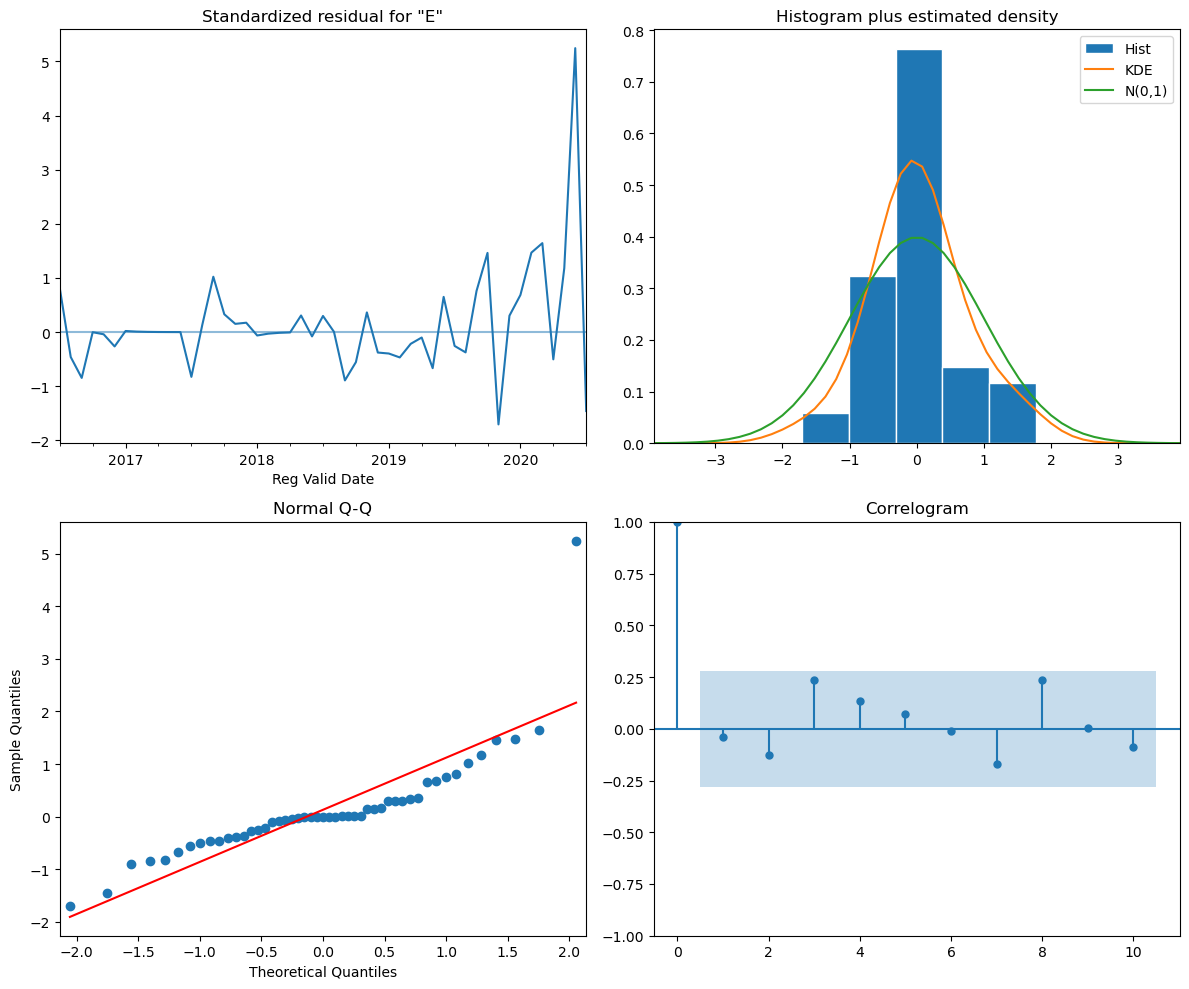

In [102]:
model = SARIMAX(train_KINGS, order=(1,1,1), 
                seasonal_order=(0, 2, [], 12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

Here, looking at the residual information, we can see that they are very close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant. These results suggest that the model is satisfactory to move onto validation.

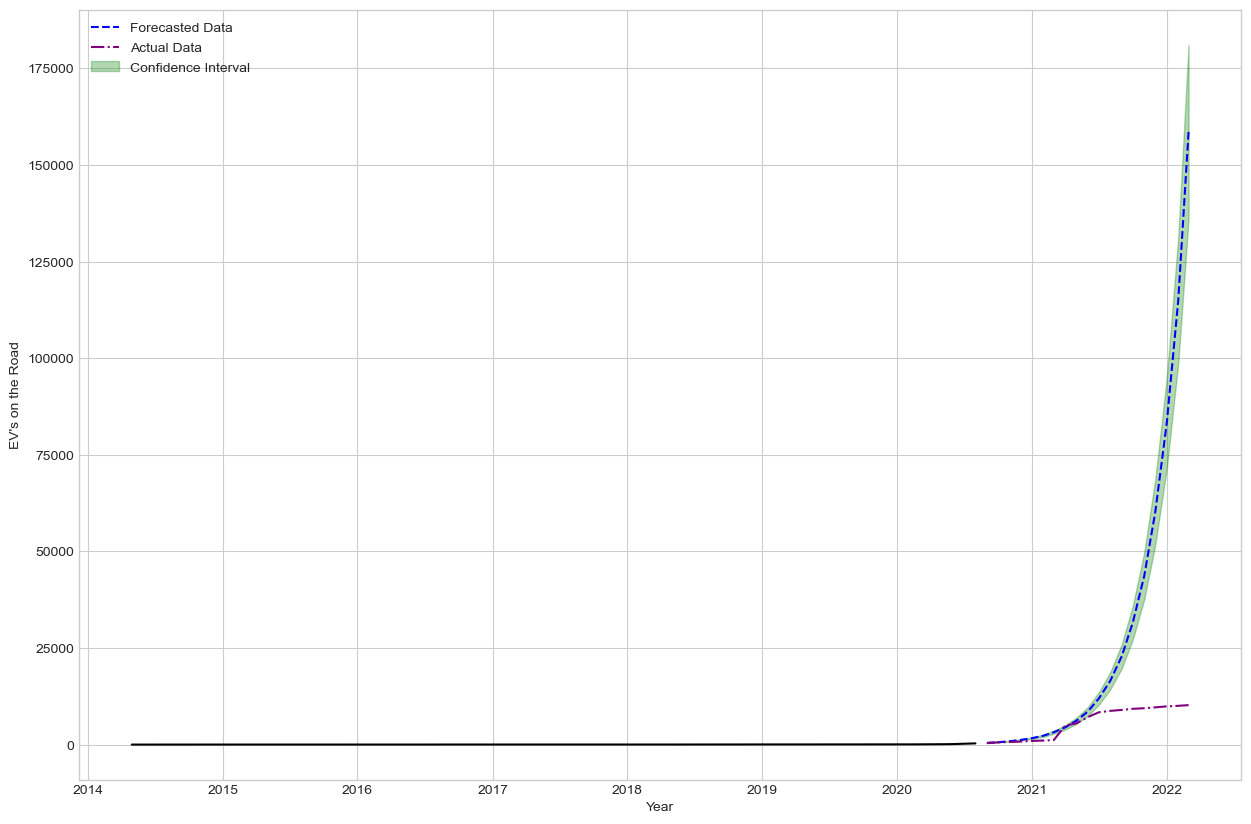

In [103]:
df_king_forecast = get_forecast(model, train_KINGS, test_KINGS, plot=True)

Above, we can see that the model is able to accurately forecast data into the future. The actual observed data is well within the confidence interval of our model's forecasts.

### Future Predictions
#### Fitting Model to All Observed Data
Now that we know that our model can accurately make predictions about the future electric vehicle counts in each county, we can use the same parameters to build a model on the whole observed dataset without splitting it into train/test sets.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43123D+00    |proj g|=  1.47292D-01

At iterate    5    f=  5.41982D+00    |proj g|=  3.94871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   2.259D-05   5.420D+00
  F =   5.4198188104042329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    EV's on the Road   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(0, 2, [], 12)   Log Likelihood                -514.883
Date:                             Wed, 16 Nov 2022   AIC                           1035.766
Time:                                     19:40:18   BIC                           1042.424
Sample:                                 04-30-2014   HQIC                          1038.404
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7962      0.200      3.989      0.000       0.405       1.187
ma.L1         -0.5324      0.288     -1.849      0.064      -1.097       0.032
sigma2      2.242e+05   8202.737     27.331      0.000    2.08e+05     2.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):              7504.07
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):           79810.67   Skew:                             6.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

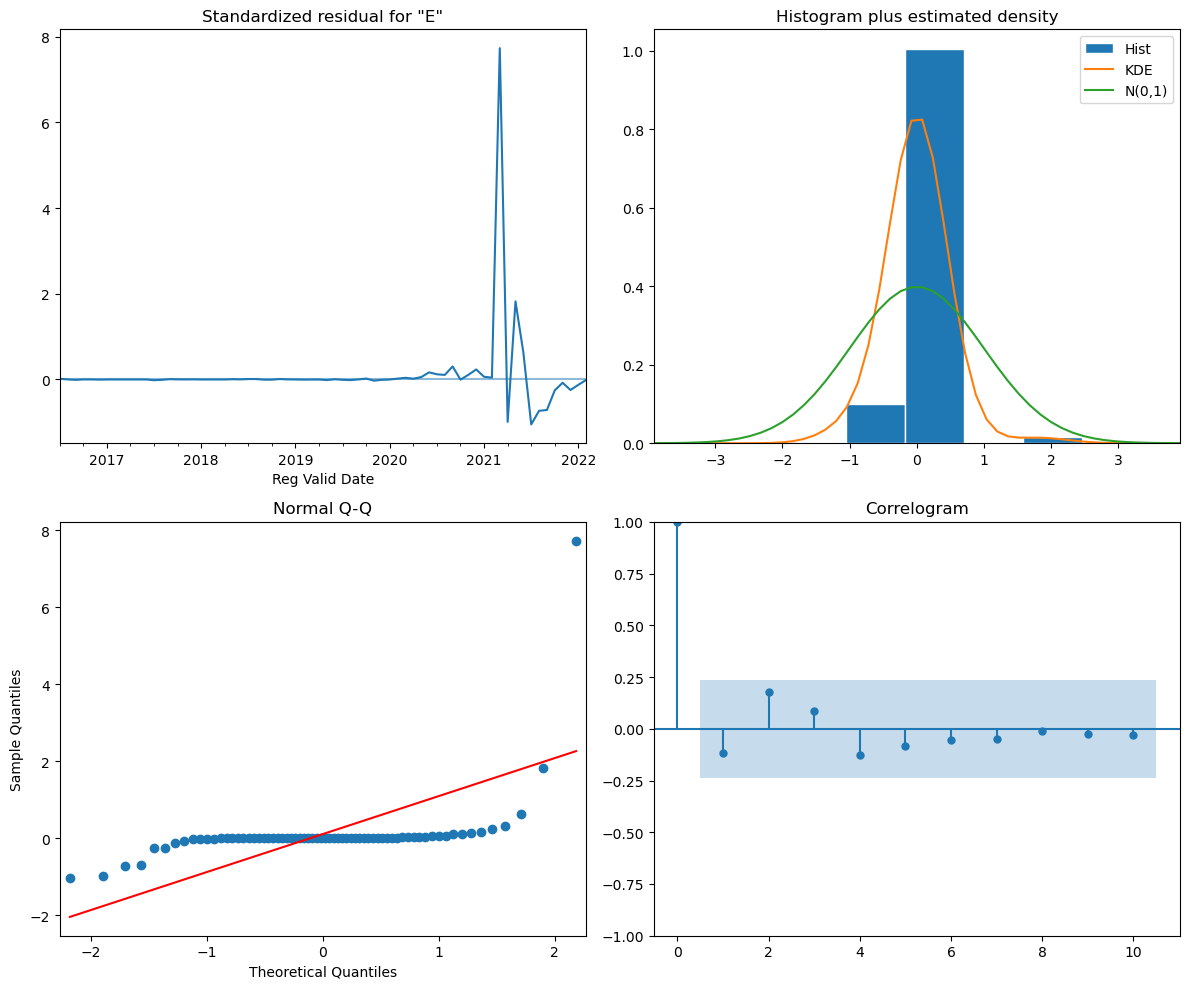

In [104]:
model = SARIMAX(county_information['KINGS']['df'], order=(1,1,1), 
                seasonal_order=(0,2,[],12), enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

Above we can see that the residuals for this model are less normally distributed compared to the test model. However, they are still fairly close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant.

#### Plotting & Saving Predictions
Using our model, we can predict the future counts of electric vehicles in King County and plot them. 

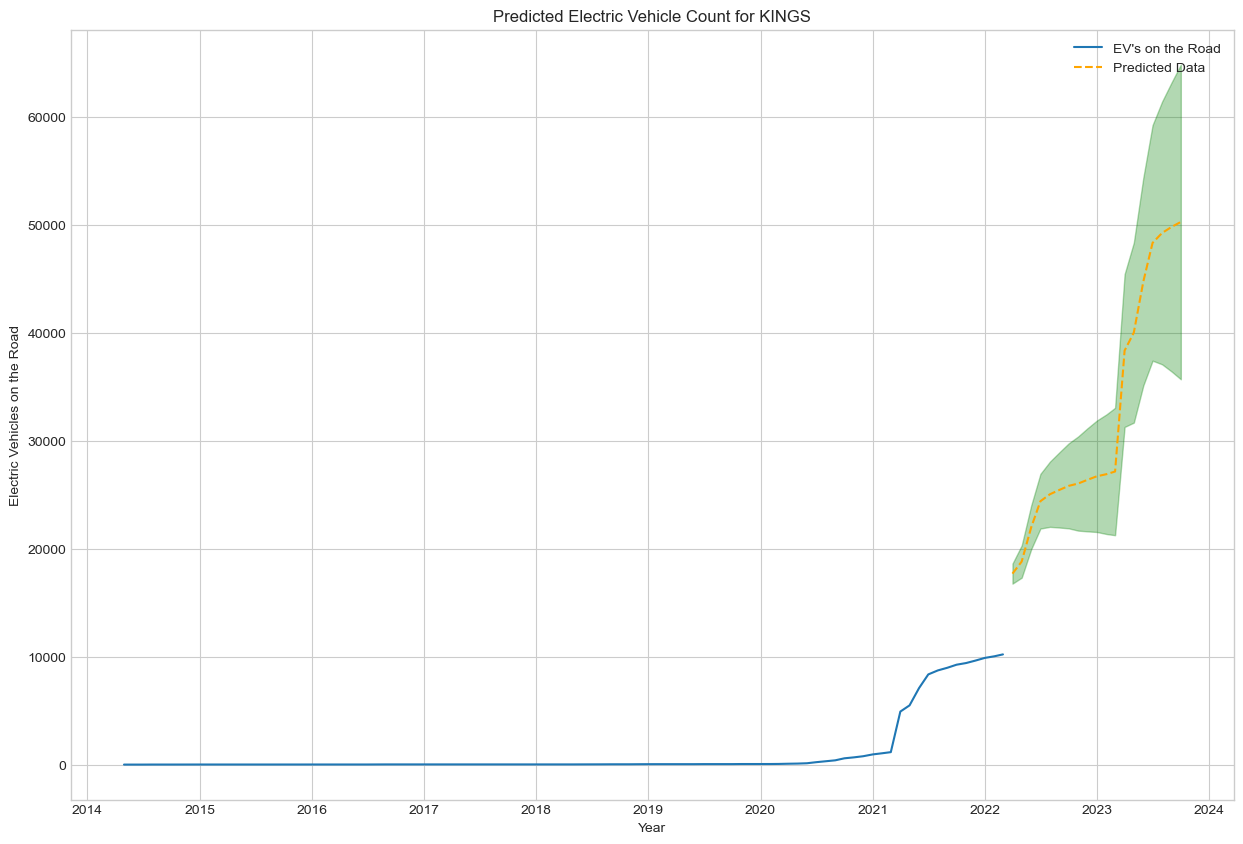

In [105]:
#creating a df of predictions and plotting
df_KINGS_preds = get_prediction(model, county_information['KINGS']['df'], 
                               test_KINGS, 'KINGS', plot=True)

The model is predicting that the amount of electric vehicles in King County are going to keep increasing almost linearly based on the mean values. If we look at the upper confidence interval though, we can see that the increase could keep an exponential pattern.

In [106]:
#saving predictions df to dict for later use
county_information['KINGS']['Predictions'] = df_KINGS_preds

In [107]:
df_KINGS_preds.head()

,Lower Confidence Interval,Upper Confidence Interval,Predictions
2022-03-31,16768.235189,18624.264014,17696.249601
2022-04-30,17321.364122,20312.461780,18816.912951
2022-05-31,19963.657888,24016.930759,21990.294323
2022-06-30,21873.806846,26943.872719,24408.839783
2022-07-31,22031.344775,28076.871797,25054.108286


# NASSAU
### Seasonality Check

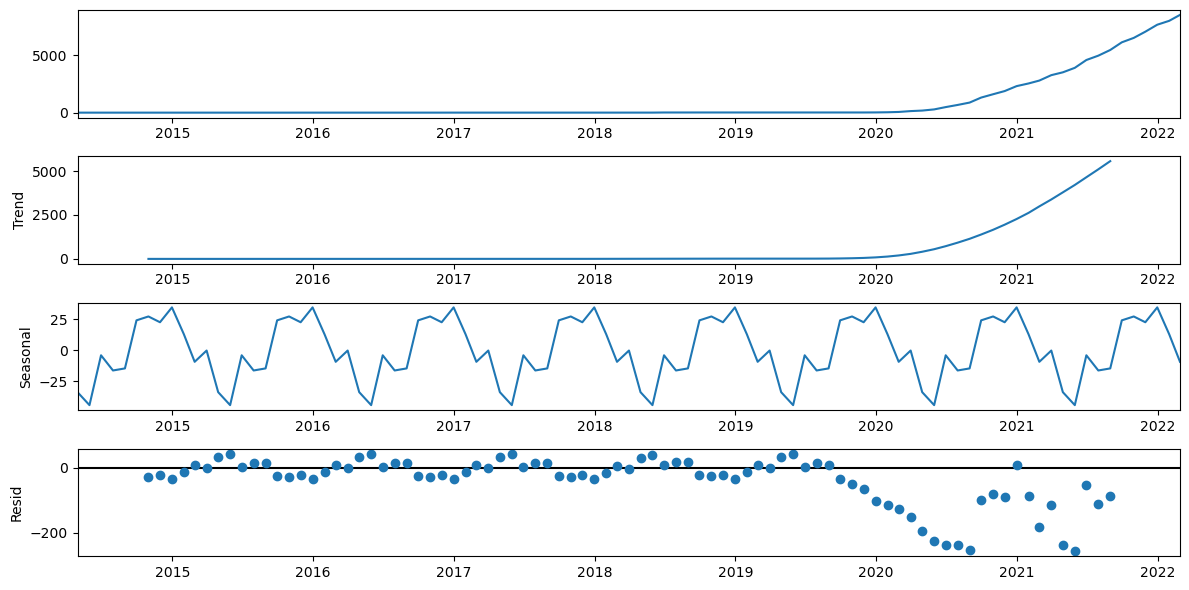

In [108]:
plt.rcParams['figure.figsize']=(12,6)
decomp = tsa.seasonal_decompose(county_information['NASSAU']['df'])
decomp.plot();

Above we can see that there is a clear trend upwards in electric vehicle counts in Snohomish county. Additionally, we can see that there is a relatively small seasonality to it.

### train_test_split
After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Pierce County resulted in the best performance.

In [111]:
#splitting dataset into train and test sets for validation
train_NASSAU, test_NASSAU = train_test_split_ts(county_information['NASSAU']['df'], 
                                            0.75, 0.25)

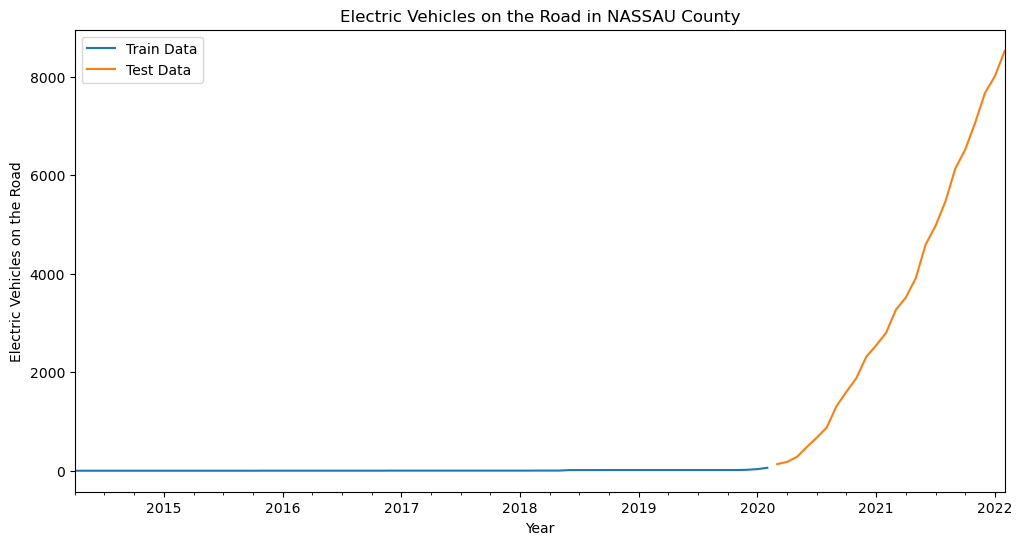

In [116]:
#plotting train and test sets
plot_train_test_split(train_NASSAU, test_NASSAU, 'NASSAU')

### Finding Best Parameters with Auto-Arima

In [113]:
auto_model = pm.auto_arima(train_NASSAU, start_p=0, start_q=0, d=1, max_p=4, 
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0, 
                           m=12, verbose=2)
auto_model.summary()

/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sar

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -166.885
Date:                Wed, 16 Nov 2022   AIC                            341.770
Time:                        19:57:09   BIC                            350.764
Sample:                    04-30-2014   HQIC                           345.343
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8210      0.932      1.953      0.051      -0.006       3.649
ar.L2         -0.8464      0.997     -0.849      0.396      -2.800       1.107
ma.L1         -0.6101      0.960     -0.636      0.525      -2.491       1.271
sigma2         6.5638      0.505     13.003      0.000       5.574       7.553
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               523.12
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             182.57   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (2,1,1) for the ARIMA order. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24311D+00    |proj g|=  8.48787D-02

At iterate    5    f=  2.23665D+00    |proj g|=  3.43039D-02

At iterate   10    f=  2.23337D+00    |proj g|=  3.68034D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   6.077D-06   2.233D+00
  F =   2.2333688942125831     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   71
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -158.569
Date:                Wed, 16 Nov 2022   AIC                            325.138
Time:                        19:59:06   BIC                            334.016
Sample:                    04-30-2014   HQIC                           328.656
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4791      1.457      1.015      0.310      -1.377       4.335
ar.L2          0.1208      1.898      0.064      0.949      -3.600       3.841
ma.L1         -0.1770      1.476     -0.120      0.905      -3.071       2.717
sigma2         6.2055      0.472     13.139      0.000       5.280       7.131
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               588.62
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             147.13   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

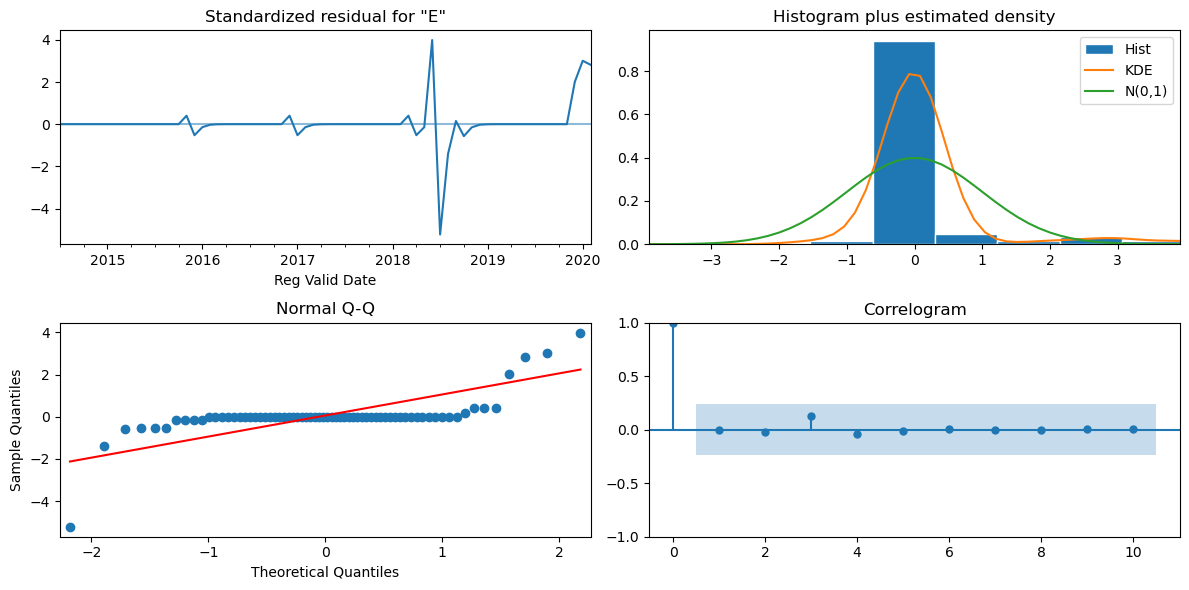

In [115]:
#fitting SARIMAX model with best params
model = SARIMAX(train_NASSAU, order=(2,1,1), 
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

Above, we can see that the residuals are almost perfectly normally distributed. This indicates that the parameters chosen above were successful in removing the seasonality and the trend. Additionally, even though some of the coefficients have values higher than 0.05 (our chosen alpha value), based on the AIC score these parameters resulted in the best model. So we will be moving on with this model.

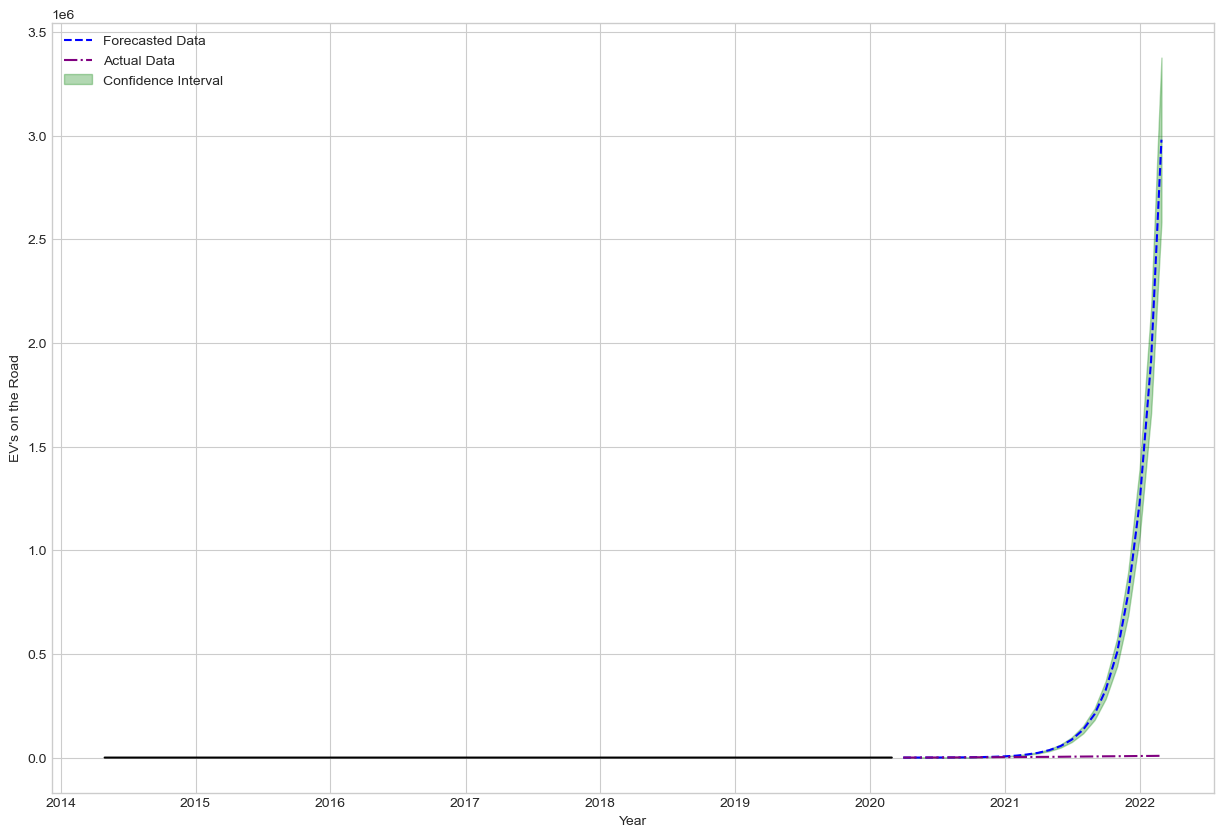

In [117]:
df_NASSU_forecast = get_forecast(model, train_NASSAU, test_NASSAU, plot=True)

Here, we can see that the forecasted data stays lower than the actual observed data. However, the observed data is still within our confidence interval. Therefore, we can move onto fitting the model to all observed data.

### Future Predictions
#### Fitting Model to All Observed Data

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99809D+00    |proj g|=  3.12785D+00

At iterate    5    f=  5.46944D+00    |proj g|=  7.29229D-01

At iterate   10    f=  5.45688D+00    |proj g|=  5.04579D-02

At iterate   15    f=  5.45681D+00    |proj g|=  1.49949D-02

At iterate   20    f=  5.44738D+00    |proj g|=  7.98777D-02

At iterate   25    f=  5.44467D+00    |proj g|=  5.85394D-02

At iterate   30    f=  5.44450D+00    |proj g|=  6.83222D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       EV's on the Road   No. Observations:                   95
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -517.227
Date:                Wed, 16 Nov 2022   AIC                           1042.454
Time:                        20:03:22   BIC                           1052.541
Sample:                    04-30-2014   HQIC                          1046.525
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7228      0.126      5.727      0.000       0.475       0.970
ar.L2          0.3154      0.135      2.342      0.019       0.051       0.579
ma.L1         -1.8953      0.345     -5.488      0.000      -2.572      -1.218
sigma2      1241.9810    457.040      2.717      0.007     346.199    2137.763
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):               330.14
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):          176955.29   Skew:                             1.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

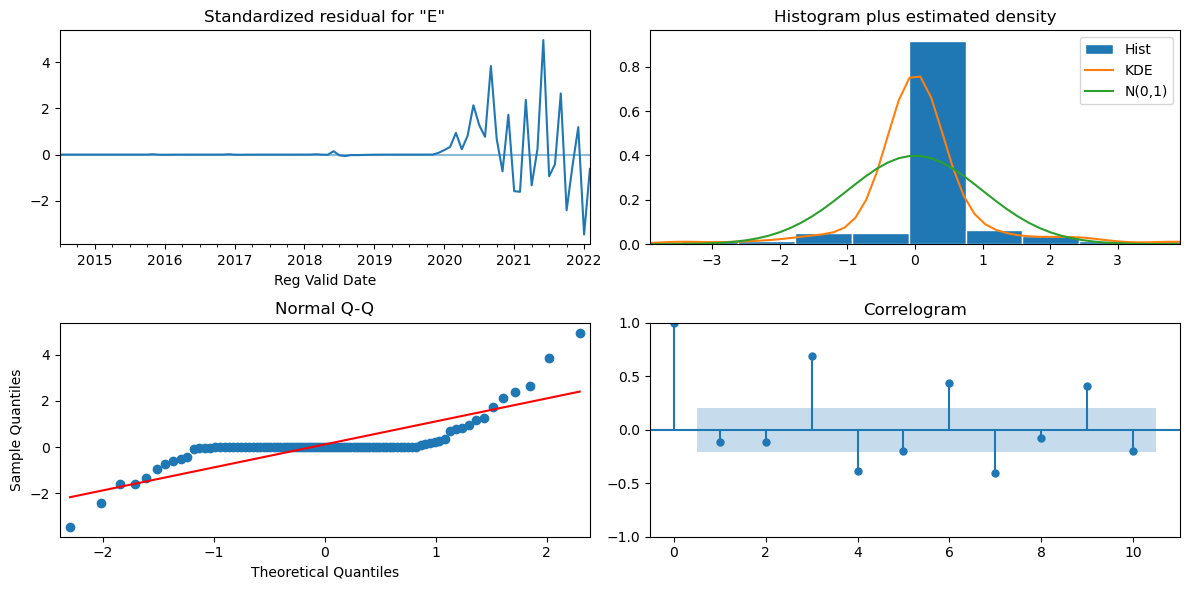

In [119]:
model = SARIMAX(county_information['NASSAU']['df'], order=(2,1,1), 
                enforce_invertibility=False, 
                enforce_stationarity=False).fit()
evaluate_model(model)

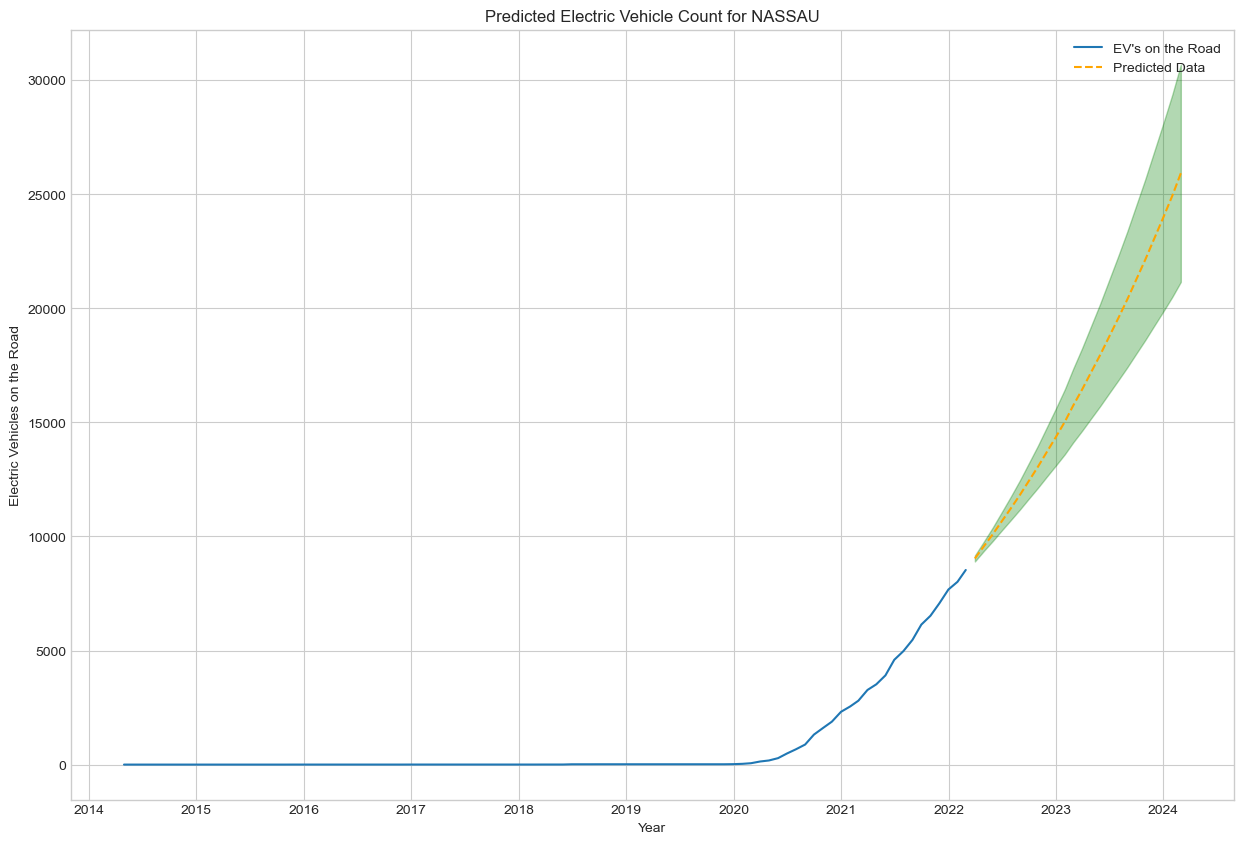

In [123]:
#getting and plotting predictions
df_NASSAU_preds = get_prediction(model, county_information['NASSAU']['df'], 
                               test_NASSAU, 'NASSAU', plot=True)

Once again, looking at the residuals, we can see that they have a fairly normal distribution. Even though some of the p-values are once again higher than the 0.05 threshold, the parameters seem to generate a model that can accurately predict the future values.

#### Plotting & Saving Predictions

In [124]:
#saving predictions
county_information['NASSAU']['Predictions'] = df_NASSAU_preds